# import

In [183]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import re
from datetime import datetime, timedelta
from  collections import Counter
import random 
import itertools as it
from scipy import stats

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import re
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from textblob import TextBlob
from statsmodels.stats.multitest import multipletests
import category_encoders as ce 
import json




# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/grab-trip-advisor/grab_ta_second.csv
/kaggle/input/michelin-restaurants/one-star-michelin-restaurants.csv
/kaggle/input/michelin-restaurants/three-stars-michelin-restaurants.csv
/kaggle/input/michelin-restaurants/two-stars-michelin-restaurants.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

In [184]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [185]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [186]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [187]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [188]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [189]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [190]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [191]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [192]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [193]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [195]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18912,id_321,Athens,"['Fast Food', 'Mediterranean', 'Greek']",322.0,$,35.0,"[['the best sandwich makers !', 'Tasteful and ...",/Restaurant_Review-g189400-d7988552-Reviews-Gu...,d7988552,1,5.0
18005,id_589,Amsterdam,"['Dutch', 'Vegetarian Friendly', 'Gluten Free ...",590.0,$$ - $$$,157.0,"[['Nice place', 'A gem'], ['12/24/2017', '12/0...",/Restaurant_Review-g188590-d2402562-Reviews-Re...,d2402562,1,4.5
13983,id_7261,London,"['Bar', 'British', 'Pub', 'International']",7270.0,$$ - $$$,59.0,"[['JUST LIKE MOTHER MAKES!', 'Ok'], ['08/09/20...",/Restaurant_Review-g186338-d698142-Reviews-The...,d698142,1,4.0
29788,id_159,Budapest,"['Italian', 'European', 'Eastern European', 'C...",160.0,$$ - $$$,644.0,"[['Lovely neighbourhood restaurant', 'Lovely s...",/Restaurant_Review-g274887-d1171370-Reviews-Ma...,d1171370,1,4.0
32273,id_4911,Paris,"['Italian', 'Pizza']",4912.0,$$ - $$$,45.0,"[['Disappointing'], ['04/23/2015']]",/Restaurant_Review-g187147-d6210849-Reviews-Re...,d6210849,1,4.0


In [196]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [197]:
# Для примера я возьму столбец Number of Reviews
#data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [198]:
#data['Number_of_Reviews_isNAN']

In [199]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
#data['Number of Reviews'].fillna(0, inplace=True)

In [200]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
#  Пробуем заменить 0
data['Number of Reviews'].fillna(0, inplace=True)
data['Number_of_Reviews_isNAN'].sum()

3200

In [201]:
data['Cuisine_Style_isNAN'] =  pd.isna(data['Cuisine Style']).astype('uint8')
 #  Заменяем на строку "пустой список", далее требуется обработка
data['Cuisine Style'].fillna('[]', inplace=True)
data['Cuisine_Style_isNAN'].sum()

11590

In [202]:
data['Reviews_isNAN'] =  pd.isna(data['Reviews']).astype('uint8')
#  Заменяем на строку "пустой список", далее требуется обработка
data['Reviews'].fillna('[[], []]', inplace=True)
data['Reviews_isNAN'].sum()

2

In [203]:
data['Price_Range_isNAN'] =  pd.isna(data['Price Range']).astype('uint8')
#  Заменяем на строку "-", далее требуется обработка
data['Price Range'].fillna('-', inplace=True)
data['Price_Range_isNAN'].sum()

17361

In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null object
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Reviews_isNAN              50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(4)
memory usage: 4.4+ MB


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [205]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41857
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine_Style_isNAN            2
Reviews_isNAN                  2
Price_Range_isNAN              2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [206]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [207]:
#data.head(5)

In [208]:
#data.sample(5)

In [209]:
data['City copy'] = data['City']
data = pd.get_dummies(data, columns=['City'], dummy_na=True)
data['City'] = data['City copy']
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City
48468,id_4385,"['Italian', 'Pizza']",4386.0,$$ - $$$,86.0,"[[], []]",/Restaurant_Review-g187791-d1011175-Reviews-Pi...,d1011175,1,3.5,...,0,0,0,1,0,0,0,0,0,Rome
41758,id_1347,[],1348.0,-,9.0,"[['THE BEST!'], ['02/06/2018']]",/Restaurant_Review-g189158-d5963234-Reviews-Ca...,d5963234,1,5.0,...,0,0,0,0,0,0,0,0,0,Lisbon
37441,id_5218,['Cafe'],5221.0,-,3.0,"[[], []]",/Restaurant_Review-g187514-d4713154-Reviews-Ca...,d4713154,1,4.5,...,0,0,0,0,0,0,0,0,0,Madrid
36911,id_809,"['Dutch', 'European', 'Vegetarian Friendly', '...",811.0,$$ - $$$,142.0,"[['Great moment', 'Such a surprise'], ['12/20/...",/Restaurant_Review-g188590-d3418462-Reviews-Ba...,d3418462,1,4.0,...,0,0,0,0,0,0,0,0,0,Amsterdam
25023,id_2064,"['European', 'Czech']",2067.0,-,0.0,[['Popelky has all you need need for a cheep.....,/Restaurant_Review-g274707-d7124521-Reviews-U_...,d7124521,1,5.0,...,0,0,1,0,0,0,0,0,0,Prague


#### Возьмем следующий признак "Price Range".

In [210]:
data['Price Range'].value_counts()

$$ - $$$    23041
-           17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [211]:
# Ваша обработка 'Price Range'
# На Price Range неудобно смотреть, закодируем потом, а пока обзовем по человечески
price_map = {'$$$$': 'high', '$$ - $$$': 'middle', '$': 'low', '-': 'unknown'}
data['Price_Range'] = data['Price Range'].map(price_map)
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City,Price_Range
44756,id_4370,"['Wine Bar', 'French']",4371.0,$$ - $$$,43.0,"[['Great way to taste wine', 'Funky Cool Conce...",/Restaurant_Review-g187147-d8558094-Reviews-Wi...,d8558094,1,4.0,...,1,0,0,0,0,0,0,0,Paris,middle
36332,id_1898,"['Irish', 'Bar', 'Pub']",1904.0,$$ - $$$,79.0,"[['Good Guinness, Awful Burger', 'Grubby'], ['...",/Restaurant_Review-g186605-d4700399-Reviews-Th...,d4700399,1,2.5,...,0,0,0,0,0,0,0,0,Dublin,middle
12960,id_7112,['Seafood'],7121.0,$,9.0,"[['Unbeatable price for value', 'Best Chippy I...",/Restaurant_Review-g186338-d8874017-Reviews-Fi...,d8874017,1,4.5,...,0,0,0,0,0,0,0,0,London,low
47876,id_898,"['Italian', 'Seafood', 'Mediterranean', 'Veget...",899.0,$$ - $$$,83.0,"[['Good welcome', 'The perfect lunch'], ['11/2...",/Restaurant_Review-g187791-d12447364-Reviews-O...,d12447364,1,4.5,...,0,0,1,0,0,0,0,0,Rome,middle
25809,id_440,"['European', 'Scandinavian', 'Danish', 'Vegeta...",441.0,$$ - $$$,87.0,"[['Tapas style restaurant very cozy', 'Great c...",/Restaurant_Review-g189541-d8475338-Reviews-Sp...,d8475338,1,4.0,...,0,0,0,0,0,0,0,0,Copenhagen,middle


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [212]:
# тут ваш код на обработку других признаков
# .....

In [213]:
# Разбиваем Reviews на 2 текстовых поля и две даты (где они есть)
reviews = data['Reviews'].str.extract(r"\[\[\'(?P<review_text>.*)\'\]\,\s\[\'(?P<review_date>.*)\'\]\]")
reviews['review_text'] = reviews['review_text'].apply(
    lambda x: re.split('\'\s*,\s*\'', x) if not pd.isna(x) else [np.nan, np.nan]).apply(
    lambda x: [x[0], np.nan] if len(x) == 1 else x)
reviews['review_date'] = reviews['review_date'].apply(
    lambda x: re.split('\'\s*,\s*\'', x) if not pd.isna(x) else [np.nan, np.nan]).apply(
    lambda x: [x[0], np.nan] if len(x) == 1 else x)
        
data['review_text_1'] = reviews['review_text'].apply(lambda x: x[0])
data['review_text_2'] = reviews['review_text'].apply(lambda x: x[1])

data['review_date_1'] = pd.to_datetime(reviews['review_date'].apply(lambda x: x[0]))
data['review_date_2'] = pd.to_datetime(reviews['review_date'].apply(lambda x: x[1]))
               
data['review1_isNAN'] = pd.isna(data['review_date_1']).astype('uint8')
data['review2_isNAN'] = pd.isna(data['review_date_2']).astype('uint8')

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Zurich,City_nan,City,Price_Range,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN
47905,id_14301,['International'],14312.0,$$ - $$$,38.0,"[['Good', 'EVERYTHING wrong !'], ['06/05/2013'...",/Restaurant_Review-g186338-d1316815-Reviews-Th...,d1316815,1,3.0,...,0,0,London,middle,Good,EVERYTHING wrong !,2013-06-05,2013-05-02,0,0
36200,id_2061,"['Spanish', 'International', 'Mediterranean', ...",2063.0,$$ - $$$,250.0,"[['Lovely food and great service.', 'Really in...",/Restaurant_Review-g187514-d7698147-Reviews-Ai...,d7698147,1,4.0,...,0,0,Madrid,middle,Lovely food and great service.,"Really interesting cuisine, good quality",2017-10-18,2017-09-13,0,0
27726,id_3118,['Italian'],3120.0,$$ - $$$,25.0,"[['Reasonable price for Italian food', 'Love i...",/Restaurant_Review-g187323-d3491870-Reviews-Il...,d3491870,1,4.0,...,0,0,Berlin,middle,Reasonable price for Italian food,Love it!!!,2017-06-10,2016-04-27,0,0
29331,id_606,"['International', 'German']",612.0,$$$$,28.0,"[['GO HERE!', 'wonderful experience with fanta...",/Restaurant_Review-g187309-d8867751-Reviews-Th...,d8867751,1,4.5,...,0,0,Munich,high,GO HERE!,wonderful experience with fantastic servic...,2017-12-25,2017-08-14,0,0
29209,id_1517,[],1518.0,-,9.0,"[['Good libanese food', 'Great food and nice s...",/Restaurant_Review-g188644-d9750074-Reviews-Ch...,d9750074,1,4.5,...,0,0,Brussels,unknown,Good libanese food,Great food and nice service.,2016-11-20,2016-08-06,0,0


In [214]:
data['review_text_1'].fillna('', inplace=True)
data['review_text_2'].fillna('', inplace=True)

data['review_date_2'] = data.apply(lambda row: row['review_date_1'] if row['review2_isNAN'] else row['review_date_2'], axis=1)
data['review_date_1'].fillna(data['review_date_1'].min(), inplace=True)
data['review_date_2'].fillna(data['review_date_2'].min(), inplace=True)


data[['review_text_1', 'review_text_2', 'review_date_1', 'review_date_2',
       'review1_isNAN', 'review2_isNAN']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
review_text_1    50000 non-null object
review_text_2    50000 non-null object
review_date_1    50000 non-null datetime64[ns]
review_date_2    50000 non-null datetime64[ns]
review1_isNAN    50000 non-null uint8
review2_isNAN    50000 non-null uint8
dtypes: datetime64[ns](2), object(2), uint8(2)
memory usage: 1.6+ MB


In [215]:
# Преобразуем Cuisine Style из строки в список
data['Cuisine_Style'] = data['Cuisine Style'].apply(
    lambda s: re.split(r'\s*,\s*', re.sub(r'[\]\[\']', '', str(s)))).apply(
    lambda l: [c.lower().strip() for c in l])

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_nan,City,Price_Range,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN,Cuisine_Style
5131,id_5131,['Pizza'],6053.0,$,7.0,"[['my favorite take away pizza'], ['10/18/2016']]",/Restaurant_Review-g187849-d10524692-Reviews-P...,d10524692,0,0.0,...,0,Milan,low,my favorite take away pizza,,2016-10-18,2016-10-18,0,1,[pizza]
20977,id_12887,[],12897.0,-,4.0,[['Have been a customer for far too many year....,/Restaurant_Review-g186338-d4911062-Reviews-Si...,d4911062,1,3.0,...,0,London,unknown,,,2004-04-21,2004-04-21,1,1,[]
19656,id_915,[],916.0,-,12.0,"[['very good carrot cake and apple pie', 'love...",/Restaurant_Review-g189541-d12667415-Reviews-C...,d12667415,1,4.0,...,0,Copenhagen,unknown,very good carrot cake and apple pie,lovely cafe and good service,2018-01-04,2017-09-15,0,0,[]
20195,id_7387,"['Chinese', 'Asian']",7388.0,$,10.0,"[['Good prices and service', 'Low price, very ...",/Restaurant_Review-g187497-d6989056-Reviews-Ji...,d6989056,1,2.5,...,0,Barcelona,low,Good prices and service,"Low price, very low quality",2015-05-02,2015-03-25,0,0,"[chinese, asian]"
5578,id_5578,['Chinese'],1943.0,-,6.0,"[['Delicious food in an Oriental setting', 'Im...",/Restaurant_Review-g187323-d11880656-Reviews-C...,d11880656,0,0.0,...,0,Berlin,unknown,Delicious food in an Oriental setting,Important Business Club!,2017-12-20,2017-09-28,0,0,[chinese]


In [216]:
# Заполним пустые списки наиболее популярной кухней в городе
most_common = data[data['Cuisine_Style_isNAN'] == 0].groupby(
    'City')['Cuisine_Style'].sum().apply(lambda x: [x[0] for x in Counter(x).most_common(1)])
nan_indices = (data['Cuisine_Style_isNAN'] == 1)
data.loc[nan_indices, 'Cuisine_Style'] = data[nan_indices]['City'].map(most_common.to_dict())
data.sample(5)
# Можно сразу закодировать, но тогда неудобно смотреть на набор (много колонок)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_nan,City,Price_Range,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN,Cuisine_Style
46309,id_917,"['European', 'Scandinavian', 'Seafood', 'Conte...",918.0,$$ - $$$,35.0,"[['Amazing seaside view and good food', 'Horri...",/Restaurant_Review-g189934-d947342-Reviews-Boa...,d947342,1,3.5,...,0,Helsinki,middle,Amazing seaside view and good food,Horrifically slow service,2017-07-16,2017-06-08,0,0,"[european, scandinavian, seafood, contemporary]"
17932,id_11630,[],11632.0,-,79.0,"[['25', 'A relaxed haven in the big city'], ['...",/Restaurant_Review-g187147-d8848372-Reviews-25...,d8848372,1,3.0,...,0,Paris,unknown,25,A relaxed haven in the big city,2017-11-19,2017-06-04,0,0,[french]
1645,id_1645,"['American', 'Bar', 'Pub']",567.0,$$ - $$$,75.0,"[['Their fries!!', 'Best quality price burger ...",/Restaurant_Review-g189852-d9576565-Reviews-Ph...,d9576565,0,0.0,...,0,Stockholm,middle,Their fries!!,Best quality price burger in Sundyberg,2018-01-08,2017-10-02,0,0,"[american, bar, pub]"
7218,id_7218,"['American', 'Fast Food', 'International', 'Fu...",2587.0,$,50.0,"[['Decent breakfast', 'Quality food in a very ...",/Restaurant_Review-g187514-d10161466-Reviews-E...,d10161466,0,0.0,...,0,Madrid,low,Decent breakfast,Quality food in a very unusual place,2018-01-09,2018-01-01,0,0,"[american, fast food, international, fusion, p..."
48886,id_553,"['International', 'Bar', 'European', 'Spanish'...",554.0,$$ - $$$,50.0,"[['Warm and friendly', 'Super sliders!'], ['12...",/Restaurant_Review-g189541-d10481084-Reviews-V...,d10481084,1,4.0,...,0,Copenhagen,middle,Warm and friendly,Super sliders!,2017-12-28,2017-08-14,0,0,"[international, bar, european, spanish, vegeta..."


In [217]:
# Разобъем URL_TA на название ресторана, название региона и идентификатор региона
data['region_id']  = data['URL_TA'].apply(
    lambda x: 'rid-' + re.search(r'(?<=Review-g)(\d*)', x).group(0))     
    
rest_full_name = data['URL_TA'].apply(lambda x: re.search(r'(?<=Reviews-)(.*)(?=\.html)', x).group(0))

data['rest_name'] = rest_full_name.apply(lambda x: x.split('-')[0]).apply(lambda x: x.replace('_', ' '))
data['rest_region'] = rest_full_name.apply(lambda x: x.split('-')[1] if len(x.split('-')) > 1 else '')

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN,Cuisine_Style,region_id,rest_name,rest_region
3907,id_3907,[],3865.0,-,11.0,"[[], []]",/Restaurant_Review-g187849-d6576966-Reviews-Gu...,d6576966,0,0.0,...,,,2004-04-21,2004-04-21,1,1,[italian],rid-187849,Gustop,Milan_Lombardy
30613,id_1739,[],1740.0,-,0.0,"[[], []]",/Restaurant_Review-g190454-d11932473-Reviews-A...,d11932473,1,5.0,...,,,2004-04-21,2004-04-21,1,1,[european],rid-190454,Anker AKH Wien,Vienna
38083,id_4936,[],4939.0,-,7.0,"[[], []]",/Restaurant_Review-g187849-d8339879-Reviews-Pa...,d8339879,1,3.5,...,,,2004-04-21,2004-04-21,1,1,[italian],rid-187849,Panino Milano,Milan_Lombardy
37901,id_2363,"['Asian', 'Vietnamese', 'Vegetarian Friendly',...",2364.0,$,104.0,"[['Good Vietnamese food near Bastille', 'Amazi...",/Restaurant_Review-g187147-d12134038-Reviews-A...,d12134038,1,4.5,...,Good Vietnamese food near Bastille,Amazing food,2017-12-03,2017-11-04,0,0,"[asian, vietnamese, vegetarian friendly, vegan...",rid-187147,Asia Bo Bun,Paris_Ile_de_France
19785,id_1880,['Spanish'],1882.0,$$$$,47.0,"[[], []]",/Restaurant_Review-g187514-d1526715-Reviews-An...,d1526715,1,4.0,...,,,2004-04-21,2004-04-21,1,1,[spanish],rid-187514,Ansorena Taberna Vasca,Madrid


In [218]:
# И для удобства приведем типы float к uint
data['Ranking'] = data['Ranking'].astype('uint16')
data['Number of Reviews'] = data['Number of Reviews'].astype('uint16')
data['sample'] = data['sample'].astype('uint8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 59 columns):
Restaurant_id              50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null uint16
Price Range                50000 non-null object
Number of Reviews          50000 non-null uint16
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null uint8
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Reviews_isNAN              50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
City copy                  50000 non-null object
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin     

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

In [219]:
def outliers(df, feature):
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def get_stat_dif(df, feature, target, dropna=True, check=True):
    cols = df.loc[:, feature].value_counts(dropna=dropna).index
    combinations_all = list(it.combinations(cols, 2))
    p_values = []
    p_combs = []
    bonferony = []
    for comb in combinations_all:
        len0 = len(df.loc[df.loc[:, feature] == comb[0]])
        len1 = len(df.loc[df.loc[:, feature] == comb[1]])
        if check and len(df.loc[df.loc[:, feature] == comb[0]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[0], len0)
#            raise Exception(msg)
            continue
        if check and len(df.loc[df.loc[:, feature] == comb[1]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[1], len1)
#            raise Exception(msg)  
            continue
        res = stats.ttest_ind(df.loc[df.loc[:, feature] == comb[0], target],
                        df.loc[df.loc[:, feature] == comb[1], target])
        p_combs.append(comb)
        p_values.append(res.pvalue)
        if res.pvalue <= 0.05 / len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки (поправка Бонферони)', feature, comb)
            bonferony.append(comb)
    
    res = multipletests(p_values, alpha=0.05, method='holm-sidak')
    rejected = []
    for i in range(0, len(res[0])):
        if res[0][i] == True: # Гипотеза отвергается
#            print(p_combs[i], p_values[i], res[0][i])
            rejected.append(p_combs[i])
    return (rejected, bonferony)


def quick_look_numeric(df, feature):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.hist(x=df[feature].dropna())
    plt.title(f'{feature} distribution\n')
    plt.xlabel(feature)
    plt.ylabel('count')

    plt.subplot(122)
    sns.boxplot(data=df, x=feature)
    plt.title(f'{feature} boxplot\n')
    plt.xlabel(feature)
    plt.show()
    
    display(df[feature].describe())
    print(f'Пропуски: {df[feature].isna().sum()}')


def quick_look_categorical(df, feature, orient='v', height=15):
    if orient == 'v':
        plt.figure(figsize=(15, height))
        sns.countplot(data=df, x=feature, orient=orient, order=df[feature].value_counts().index)
    else:
        plt.figure(figsize=(15, height))
        sns.countplot(data=df, y=feature, orient=orient, order=df[feature].value_counts().index)
    plt.title(f'{feature} distribution\n')
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

    display(df[feature].astype('category').describe())
    print(f'Пропуски: {df[feature].isna().sum()}')



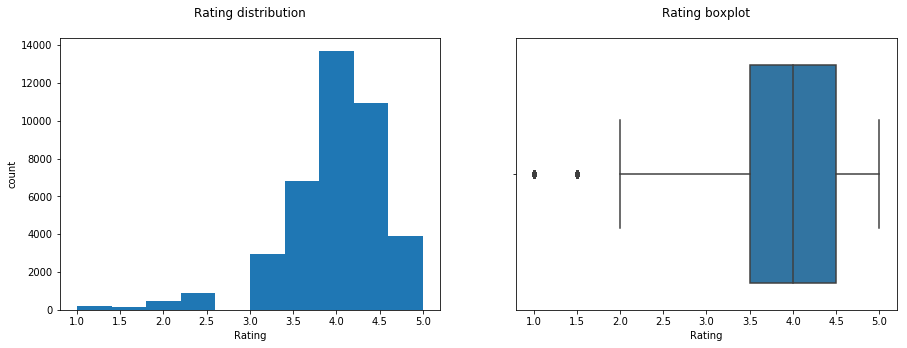

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

Пропуски: 0


In [220]:
# Целевая переменная Rating
quick_look_numeric(data.query('sample == 1'), 'Rating')

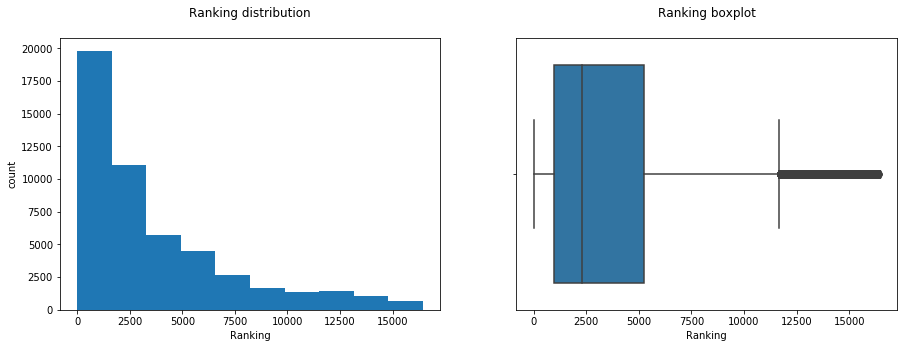

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

Пропуски: 0


In [221]:
# Ranking
quick_look_numeric(data, 'Ranking')

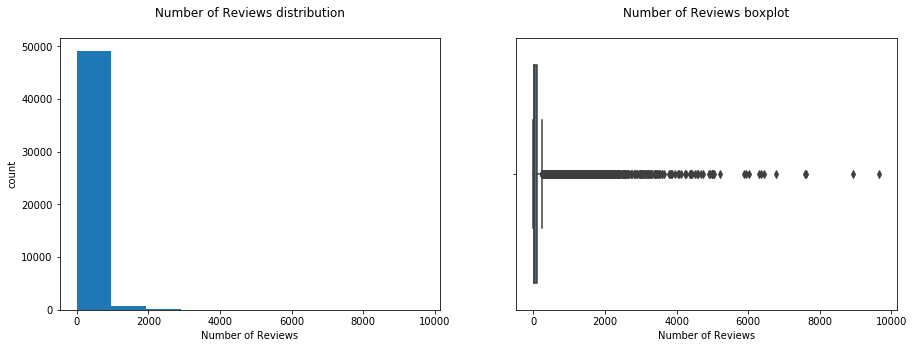

count    50000.000000
mean       116.505040
std        286.173104
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Пропуски: 0


In [222]:
# Number of Reviews
quick_look_numeric(data, 'Number of Reviews')

##### Здесь хуже явный перекос к маленьким значениям, хотя есть очень большие

In [223]:
data

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN,Cuisine_Style,region_id,rest_name,rest_region
0,id_0,"['Bar', 'Pub']",12963,$$ - $$$,4,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,,,2004-04-21,2004-04-21,1,1,"[bar, pub]",rid-187147,Le Perchoir,Paris_Ile_de_France
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106,$$ - $$$,97,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,Very good reviews!,Fine dining in Hakaniemi,2017-12-05,2017-10-29,0,0,"[european, scandinavian, gluten free options, ...",rid-189934,Ravintola Kolmon3n,Helsinki_Uusimaa
2,id_2,['Vegetarian Friendly'],810,$$ - $$$,28,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,Better than the Links,Ivy Black,2017-12-28,2017-12-06,0,0,[vegetarian friendly],rid-186525,Black Ivy,Edinburgh_Scotland
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669,$$$$,202,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,Most exquisite,Delicious and authentic,2017-12-06,2017-11-22,0,0,"[italian, mediterranean, european, vegetarian ...",rid-186338,Quirinale,London_England
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37,$$$$,162,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,Always the best in bratislava,Very good but pricey,2018-02-08,2018-01-24,0,0,"[italian, mediterranean, european, seafood, ve...",rid-274924,Massimo Ristorante,Bratislava_Bratislava_Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500,$$ - $$$,79,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,The real Italian experience!,"Wonderful food, wonderful experience",2017-12-16,2017-11-12,0,0,"[italian, vegetarian friendly, vegan options, ...",rid-187849,Rosso Brera,Milan_Lombardy
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341,$$ - $$$,542,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,Parisian atmosphere,Bit pricey but interesting decor and good...,2017-12-21,2017-12-12,0,0,"[french, american, bar, european, vegetarian f...",rid-187147,La Favorite,Paris_Ile_de_France
49997,id_1649,"['Japanese', 'Sushi']",1652,-,4,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,Good by swedish standards,A hidden jewel in the middle of Västertorp...,2016-11-03,2008-04-12,0,0,"[japanese, sushi]",rid-189852,Sushi Bar Anu,Stockholm
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641,$$ - $$$,70,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,Underground restaurant,Oldest Restaurant in Warsaw,2017-07-11,2017-06-18,0,0,"[polish, european, eastern european, central e...",rid-274856,Honoratka dawna Oberza na Miodowej,Warsaw_Mazovia_Province_Central_Poland


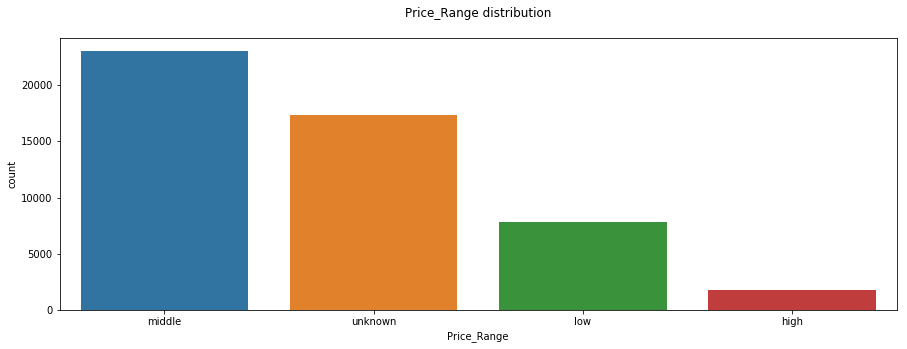

count      50000
unique         4
top       middle
freq       23041
Name: Price_Range, dtype: object

Пропуски: 0


In [224]:
# Price Range
quick_look_categorical(data, 'Price_Range', height=5)

###### Как и ожидалось большинство ресторанов относятся к средней ценовой категории, нужно что-то сделать с unknown

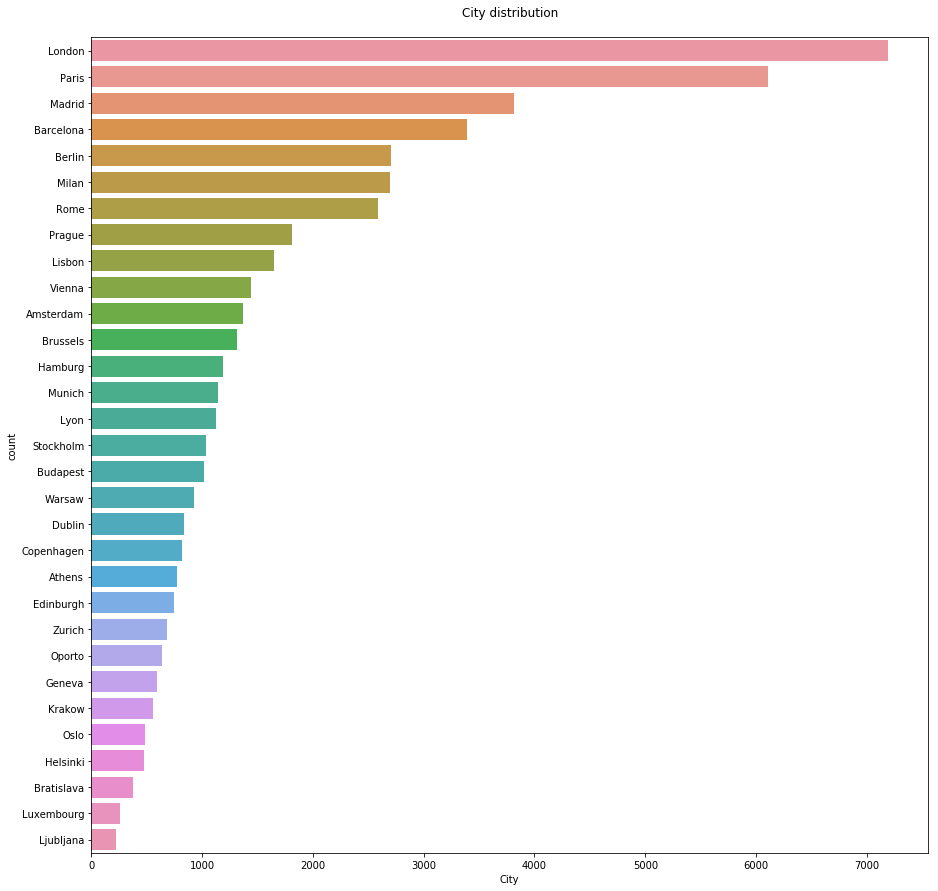

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

Пропуски: 0


In [225]:
# City
quick_look_categorical(data, 'City', orient='h')

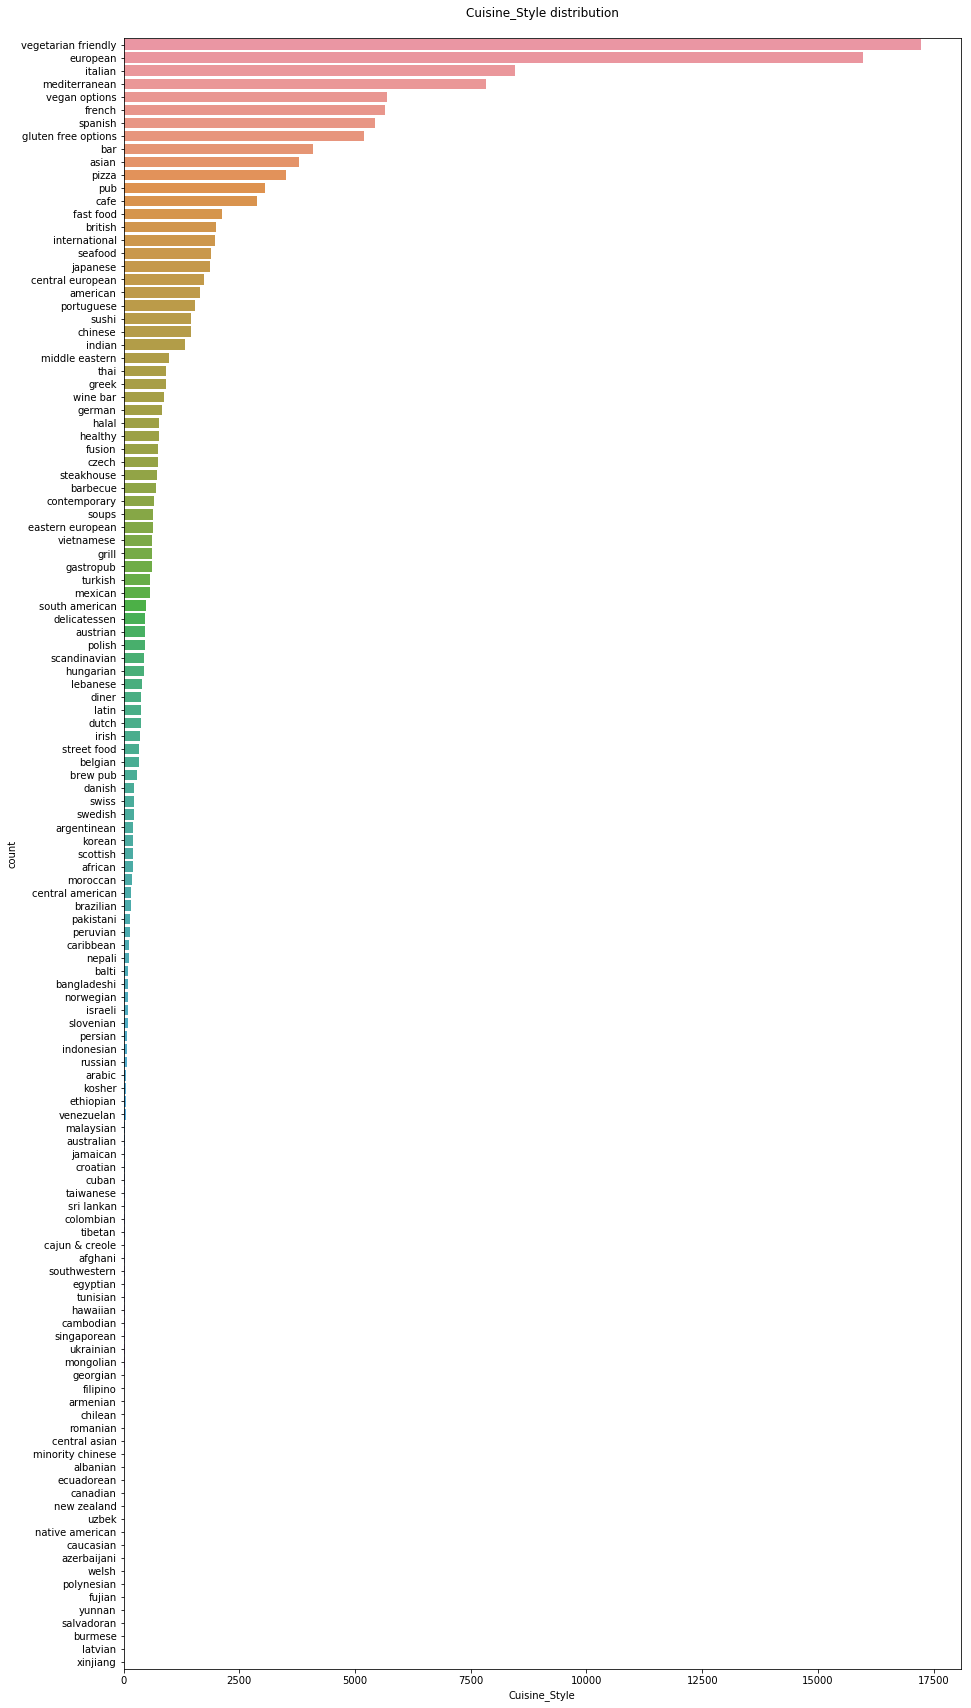

count                  131266
unique                    125
top       vegetarian friendly
freq                    17220
Name: Cuisine_Style, dtype: object

Пропуски: 0


In [226]:
# Cuisine_Style
quick_look_categorical(data.explode('Cuisine_Style'), 'Cuisine_Style', orient='h', height=30)

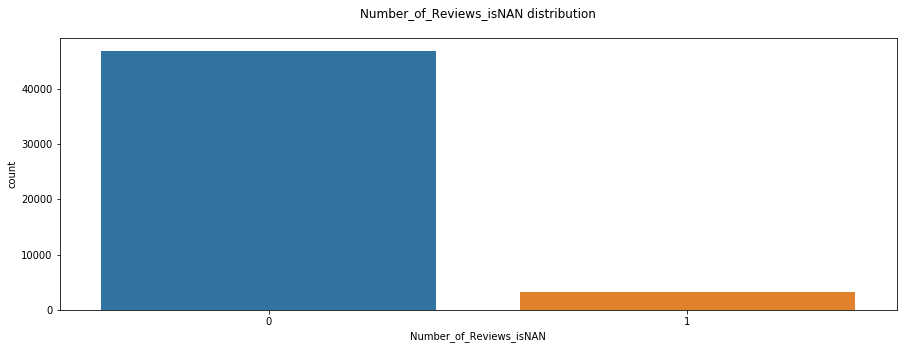

count     50000
unique        2
top           0
freq      46800
Name: Number_of_Reviews_isNAN, dtype: int64

Пропуски: 0


In [227]:
# NAN indicators
quick_look_categorical(data, 'Number_of_Reviews_isNAN', orient='v', height=5)

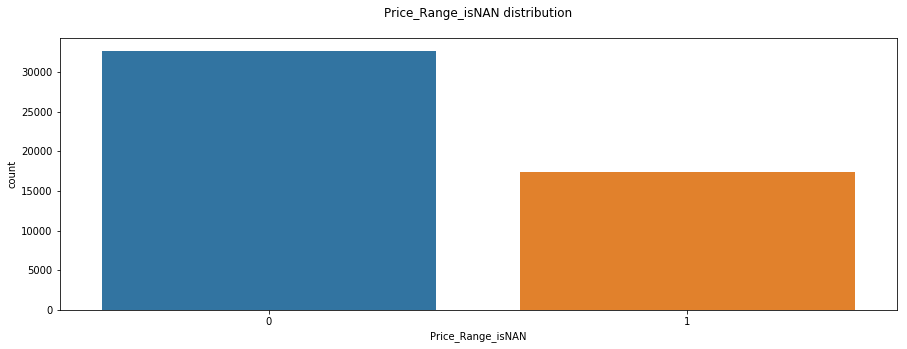

count     50000
unique        2
top           0
freq      32639
Name: Price_Range_isNAN, dtype: int64

Пропуски: 0


In [228]:
quick_look_categorical(data, 'Price_Range_isNAN', orient='v', height=5)

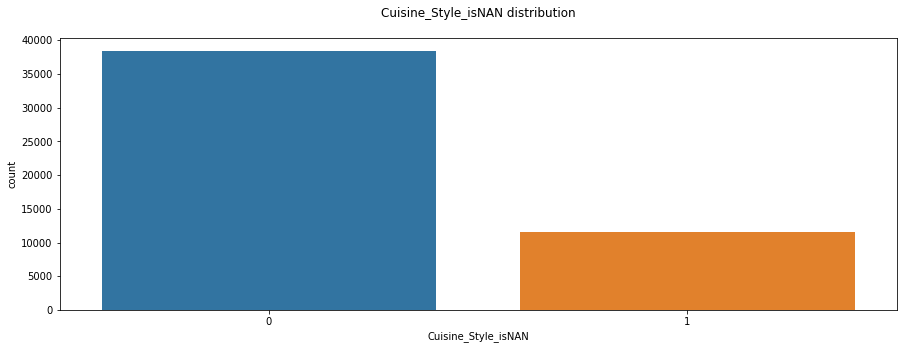

count     50000
unique        2
top           0
freq      38410
Name: Cuisine_Style_isNAN, dtype: int64

Пропуски: 0


In [229]:
quick_look_categorical(data, 'Cuisine_Style_isNAN', orient='v', height=5)

### Посмотрим распределение признака

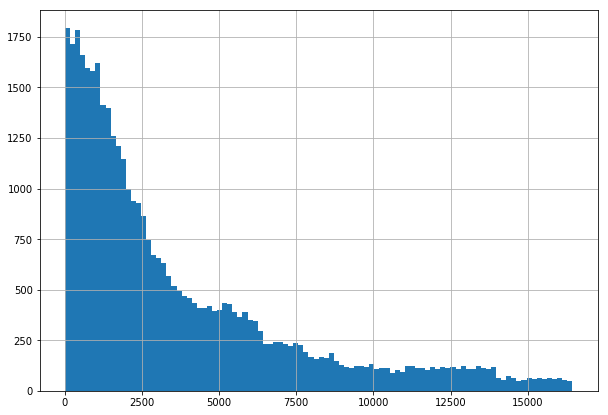

In [230]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

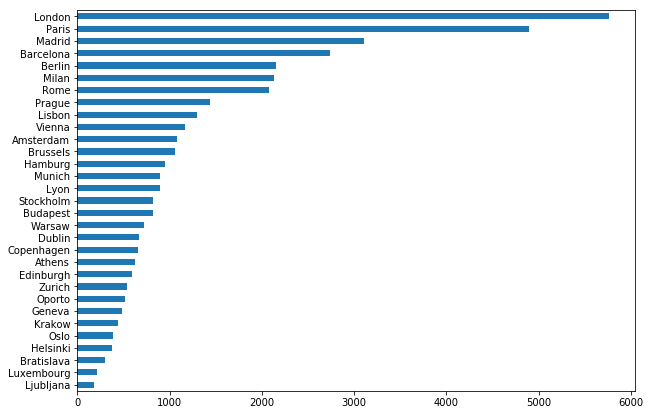

In [231]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

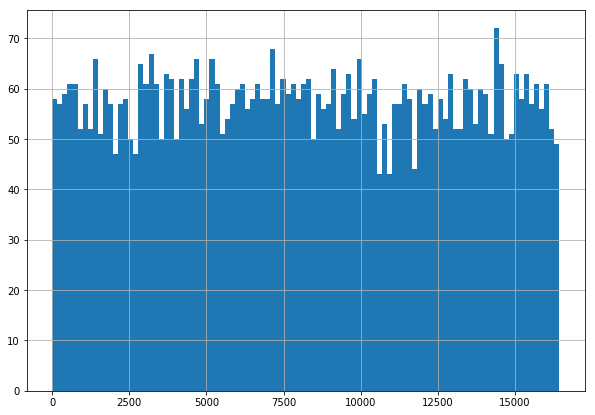

In [232]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

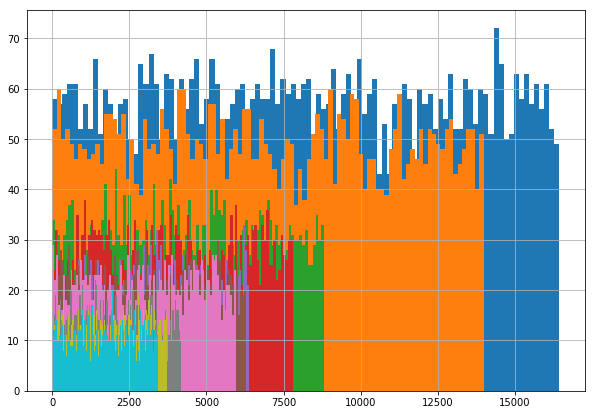

In [233]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =)

### Посмотрим распределение целевой переменной

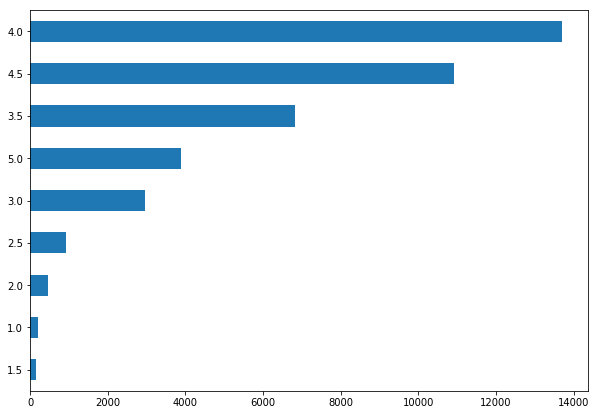

In [234]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

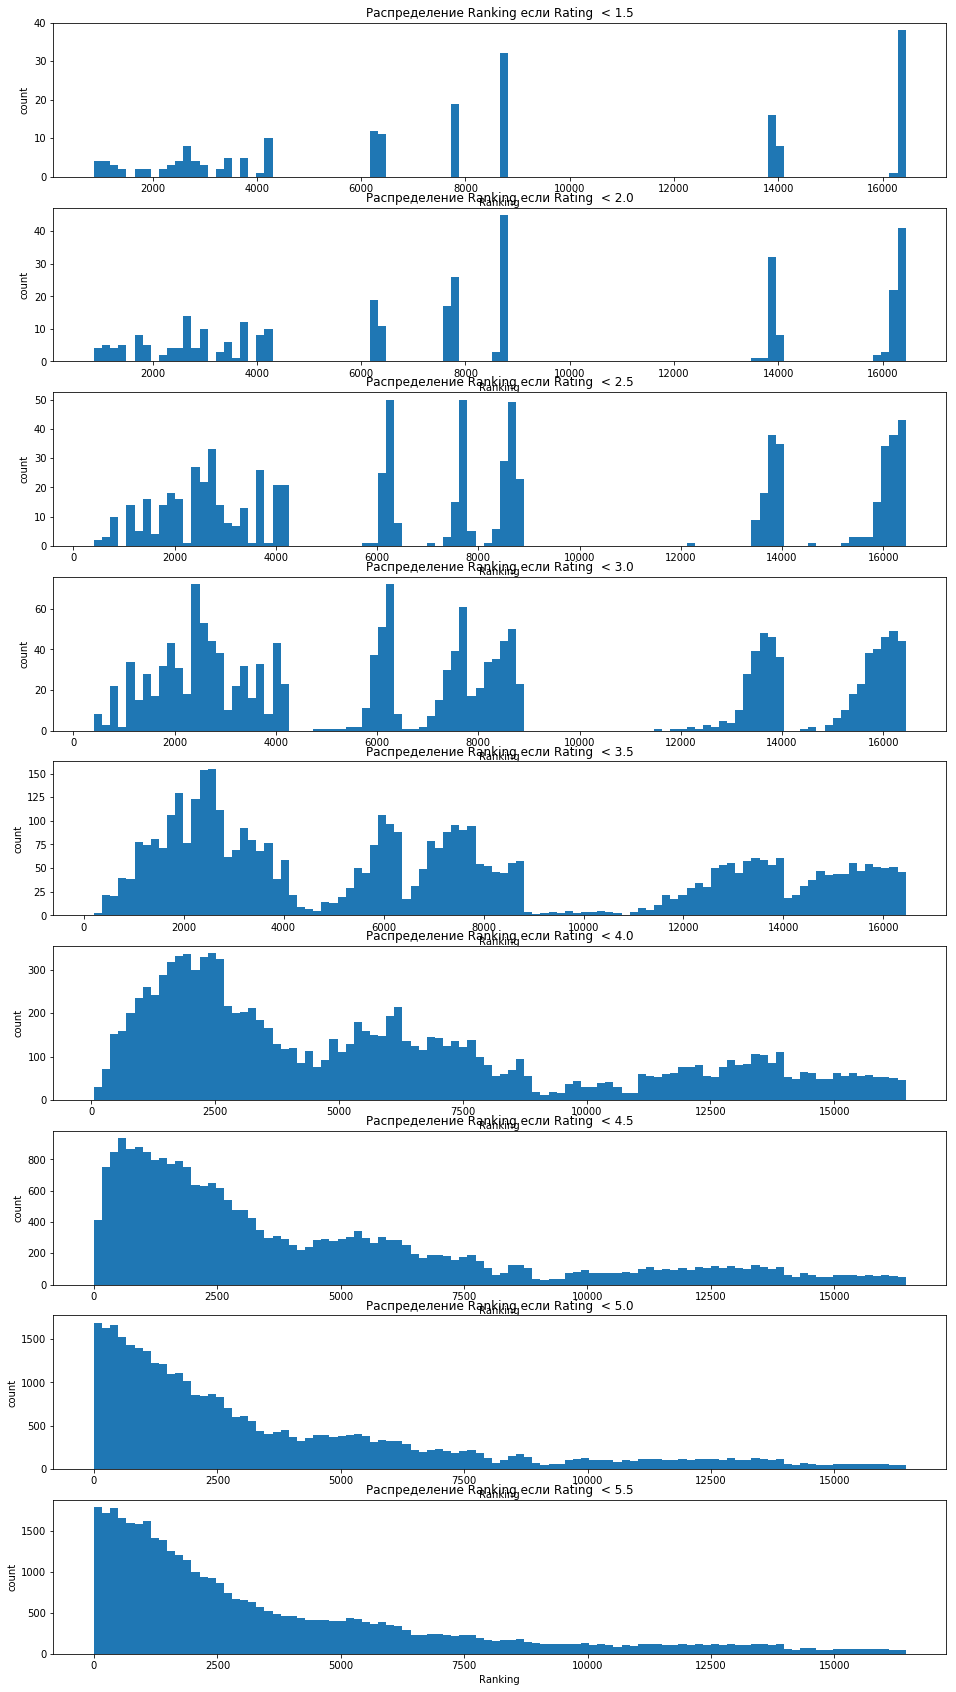

In [235]:
plt.rcParams['figure.figsize'] = (16,30)
train_df = data[data['sample'] == 1]
fig, ax = plt.subplots(9, 1)
i = 0
for rat in np.arange(1.5, 6, 0.5):
    ax[i].hist(train_df['Ranking'][train_df['Rating'] < (rat)], bins=100)
    ax[i].set_title(f'Распределение Ranking если Rating  < {rat}')
    ax[i].set_xlabel('Ranking')
    ax[i].set_ylabel('count')
    i += 1

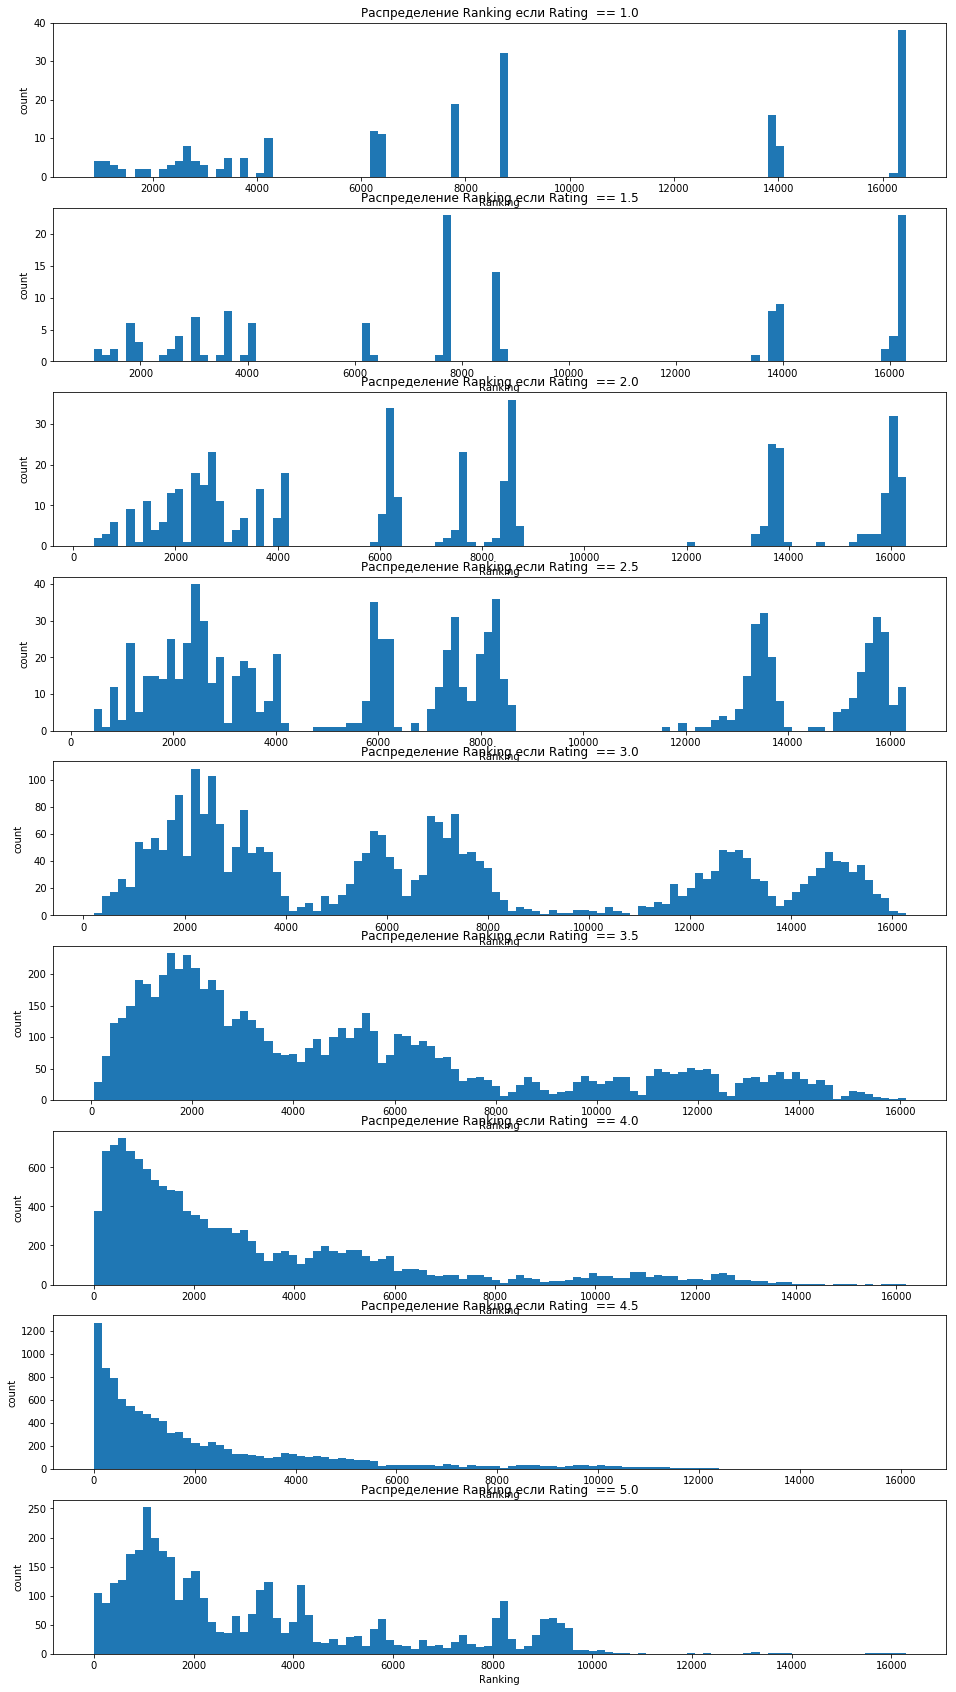

In [236]:
plt.rcParams['figure.figsize'] = (16,30)
train_df = data[data['sample'] == 1]
fig, ax = plt.subplots(9, 1)
i = 0
for rat in np.arange(1, 5.5, 0.5):
    ax[i].hist(train_df['Ranking'][train_df['Rating'] == (rat)], bins=100)
    ax[i].set_title(f'Распределение Ranking если Rating  == {rat}')
    ax[i].set_xlabel('Ranking')
    ax[i].set_ylabel('count')
    i += 1

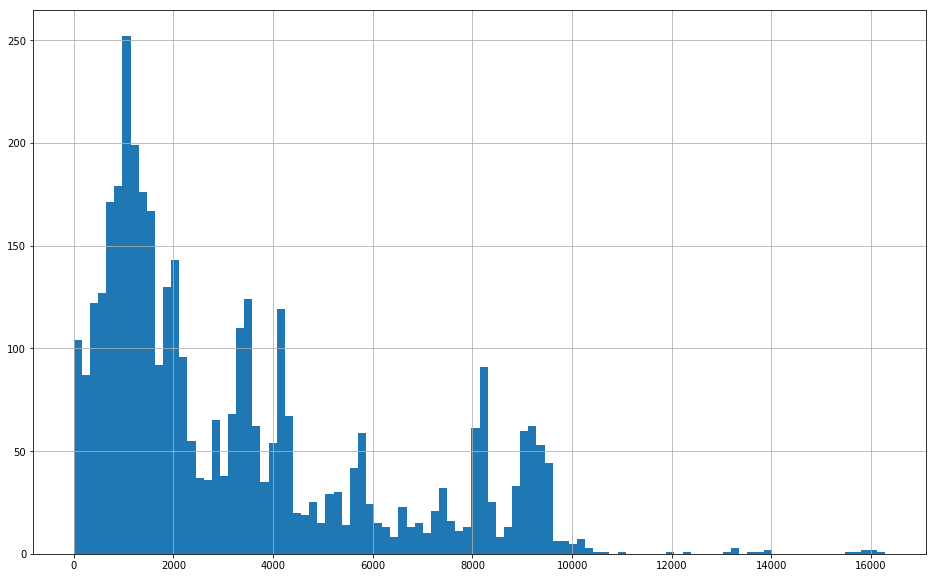

In [237]:
plt.rcParams['figure.figsize'] = (16,10)
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

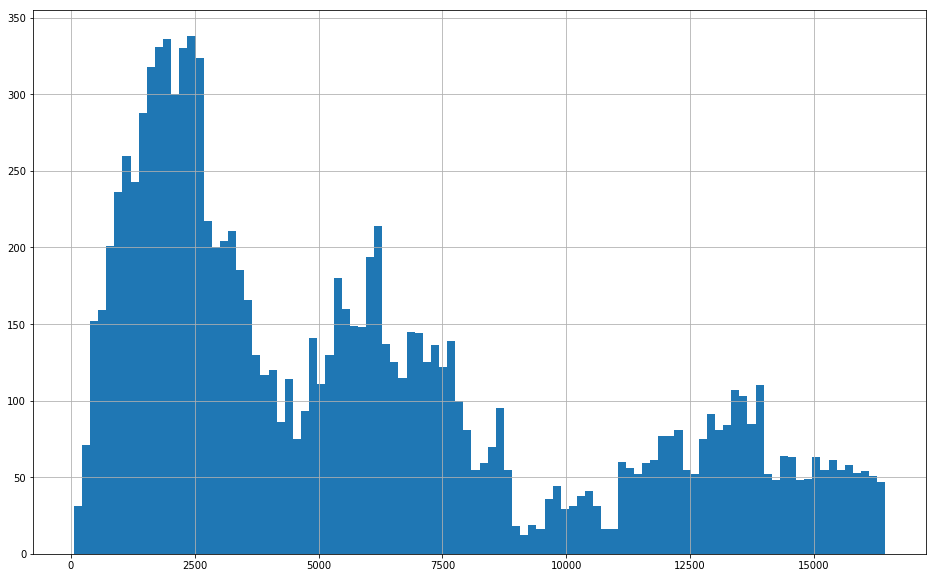

In [238]:
plt.rcParams['figure.figsize'] = (16,10)
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

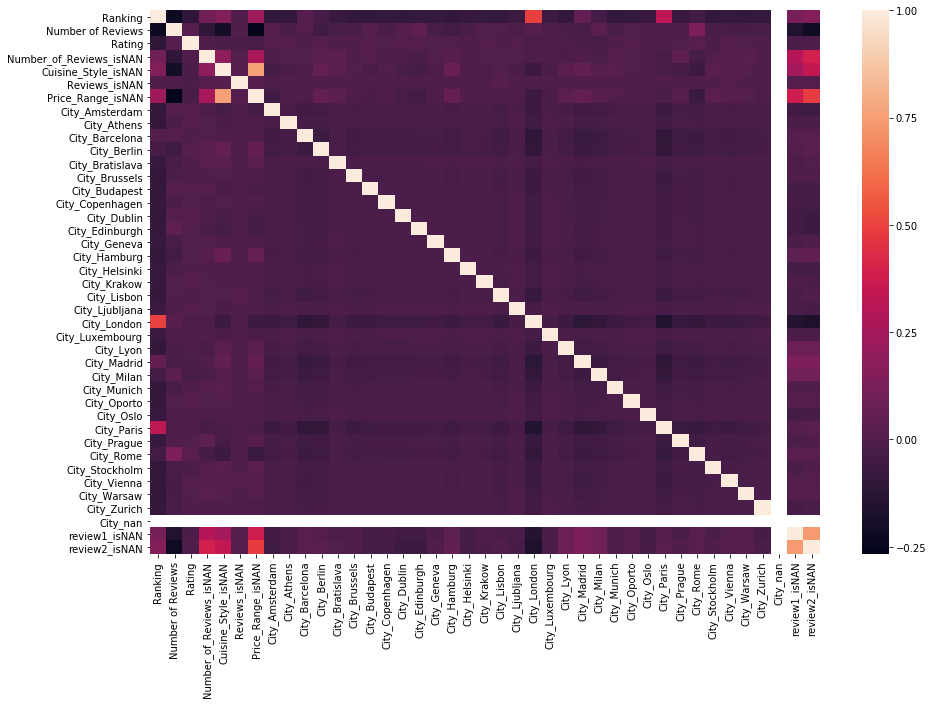

In [239]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

## Графики, графики, графики - начало

In [240]:
train_data = data.query('sample==1').drop('sample', axis=1).copy()
train_data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,Number_of_Reviews_isNAN,...,review_text_1,review_text_2,review_date_1,review_date_2,review1_isNAN,review2_isNAN,Cuisine_Style,region_id,rest_name,rest_region
12462,id_681,"['Brazilian', 'Latin', 'Barbecue', 'South Amer...",688,$$$$,130,"[['Fun Brazilian steakhouse', 'Great food!'], ...",/Restaurant_Review-g187309-d6725714-Reviews-VI...,d6725714,4.0,0,...,Fun Brazilian steakhouse,Great food!,2017-12-14,2017-02-28,0,0,"[brazilian, latin, barbecue, south american]",rid-187309,VIB Grill Lounge,Munich_Upper_Bavaria_Bavaria
31071,id_11025,"['Japanese', 'Asian']",11027,$$ - $$$,2,"[['Looking for Chinese food'], ['08/01/2015']]",/Restaurant_Review-g187147-d1071055-Reviews-No...,d1071055,3.5,0,...,Looking for Chinese food,,2015-08-01,2015-08-01,0,1,"[japanese, asian]",rid-187147,Noodle House,Paris_Ile_de_France
20762,id_2149,"['Bar', 'European', 'Pub', 'Vegetarian Friendly']",2151,$$ - $$$,69,"[['Depending on the time of day, this place a....",/Restaurant_Review-g190454-d810866-Reviews-Eur...,d810866,3.5,0,...,"Depending on the time of day, this place a...","Smoking lounge in the back, terrace on the...",2017-12-03,2017-09-06,0,0,"[bar, european, pub, vegetarian friendly]",rid-190454,Europa,Vienna
36653,id_8360,"['Moroccan', 'Mediterranean']",8361,-,2,"[['Nice food in a very quiet place'], ['05/10/...",/Restaurant_Review-g187147-d8333988-Reviews-Do...,d8333988,5.0,0,...,Nice food in a very quiet place,,2016-05-10,2016-05-10,0,1,"[moroccan, mediterranean]",rid-187147,Dona Restaurant,Paris_Ile_de_France
39127,id_237,"['German', 'European']",238,$$ - $$$,439,"[['Fantastic old bar', 'Best Fried Chicken, Ev...",/Restaurant_Review-g187323-d715372-Reviews-Hen...,d715372,4.0,0,...,Fantastic old bar,"Best Fried Chicken, Ever.",2017-11-30,2017-12-05,0,0,"[german, european]",rid-187323,Henne,Berlin


### Распределение Ranking по Rating

In [241]:
#g = sns.FacetGrid(train_data, col="Rating", col_wrap=3)
#g.map_dataframe(sns.histplot, x="Ranking")
#g.set_axis_labels("Ranking", "Count")

### Распределение Number of Reviews по Rating

In [242]:
#g = sns.FacetGrid(train_data[train_data["Number of Reviews"] > 0], col="Rating", col_wrap=3)
#g.map_dataframe(sns.histplot, x="Number of Reviews", log_scale=True)
#g.set_axis_labels("Number of Reviews", "Count")

### Распределение Cuisine Style

Text(0, 0.5, 'Cuisine Style')

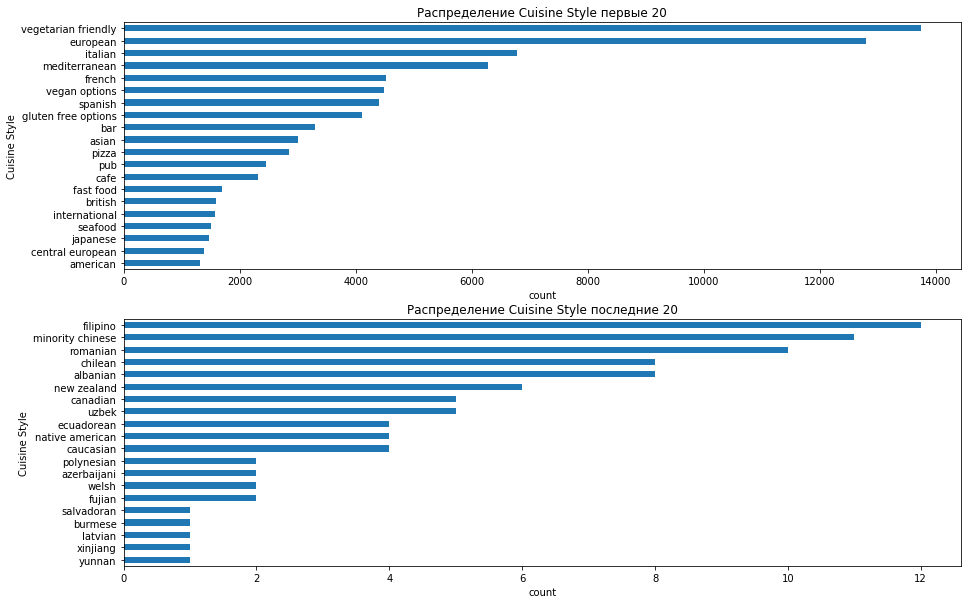

In [243]:
exploded_df = train_data.explode('Cuisine_Style') 
plt.rcParams['figure.figsize'] = (15,10)
plt.subplot(211)
ax = exploded_df['Cuisine_Style'].value_counts(ascending=True)[-20:].plot(kind='barh')
ax.set_title('Распределение Cuisine Style первые 20')
ax.set_xlabel('count')
ax.set_ylabel('Cuisine Style')
plt.subplot(212)
ax = exploded_df['Cuisine_Style'].value_counts(ascending=True)[:20].plot(kind='barh')
ax.set_title('Распределение Cuisine Style последние 20')
ax.set_xlabel('count')
ax.set_ylabel('Cuisine Style')

### Средний ранг от кухни представленной в ресторане

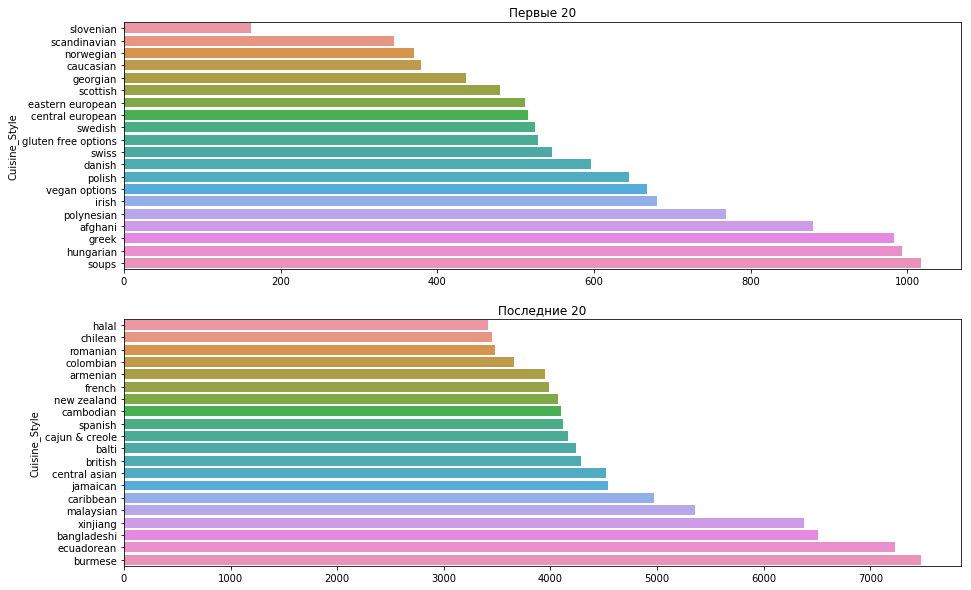

In [244]:
# Средний ранг от кухни представленной в ресторане
rank_by_style = train_data.explode('Cuisine_Style').groupby('Cuisine_Style')['Ranking'].median()
rank_by_style_first20 = rank_by_style.sort_values(ascending=True)[:20]
rank_by_style_last20 = rank_by_style.sort_values(ascending=True)[-20:]
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(211)
ax = sns.barplot(y=rank_by_style_first20.index, x=rank_by_style_first20.values, order=rank_by_style_first20.index)
_ = ax.set_title('Первые 20')
plt.subplot(212)
ax = sns.barplot(y=rank_by_style_last20.index, x=rank_by_style_last20.values, order=rank_by_style_last20.index)
_ = ax.set_title('Последние 20')

### Среднее количество озывов от кухни представленной в ресторане

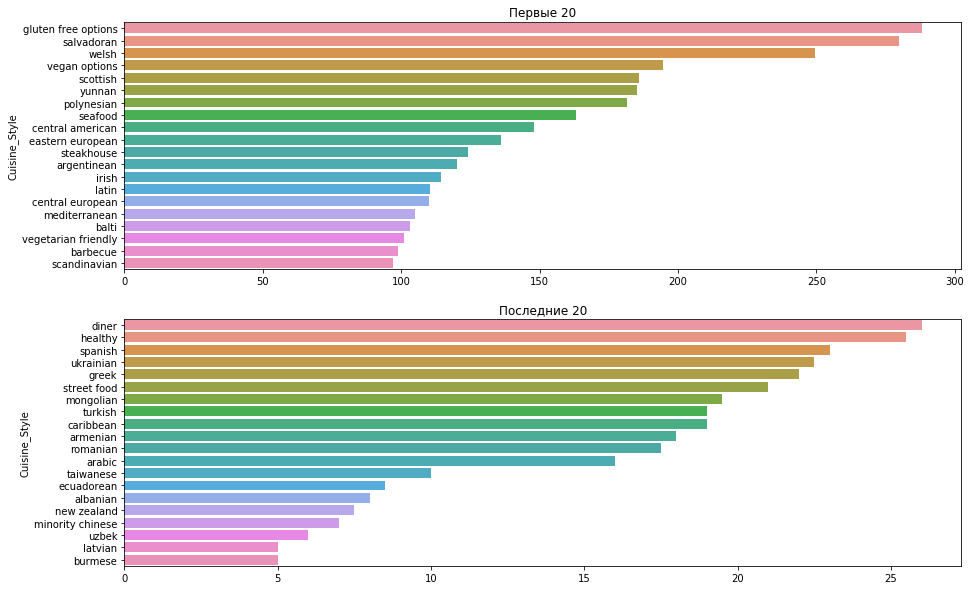

In [245]:
nofr_by_style = train_data.explode('Cuisine_Style').groupby('Cuisine_Style')['Number of Reviews'].median()
nofr_by_style_first20 = nofr_by_style.sort_values(ascending=False)[:20]
nofr_by_style_last20 = nofr_by_style.sort_values(ascending=False)[-20:]
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(211)
ax = sns.barplot(y=nofr_by_style_first20.index, x=nofr_by_style_first20.values, order=nofr_by_style_first20.index)
_ = ax.set_title('Первые 20')
plt.subplot(212)
ax = sns.barplot(y=nofr_by_style_last20.index, x=nofr_by_style_last20.values, order=nofr_by_style_last20.index)
_ = ax.set_title('Последние 20')

### Средний ранг от ценовой категории ресторана

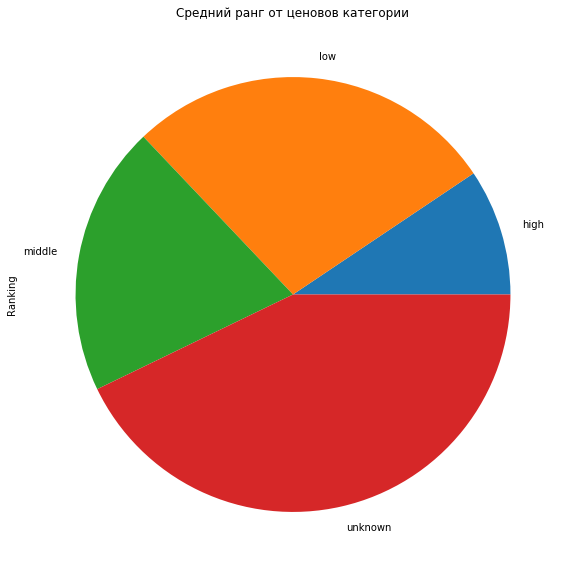

In [246]:
# Средний ранг от ценовой категории ресторана
rank_by_price = train_data.groupby('Price_Range')['Ranking'].median()
plt.rcParams['figure.figsize'] = (10, 10)
ax = rank_by_price.plot(kind='pie')
_ = ax.set_title('Средний ранг от ценовов категории')

Больший ранг у ресторанов с неуказанной ценовой категорией ???. 
Меньший у дорогих.

### Среднее количество отзывов от ценовой категории ресторана

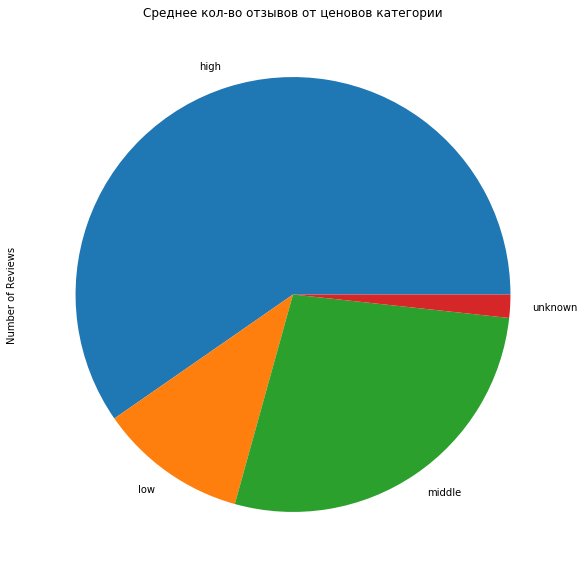

In [247]:
nofr_by_price = train_data.groupby('Price_Range')['Number of Reviews'].median()
plt.rcParams['figure.figsize'] = (10, 10)
ax = nofr_by_price.plot(kind='pie')
_ = ax.set_title('Среднее кол-во отзывов от ценовов категории')

Количество отзывов о дорогих ресторанах значительно больше, чкм о других.
Отзывов о ресторанах с неизвестной ценовой категорией очень мало. ???

### Рейтинг ресторанов по кухням (топ 5)

In [248]:
#exploded_df = train_data.explode('Cuisine_Style')
#top = exploded_df['Cuisine_Style'].value_counts()[:5].index.values
#plt.rcParams['figure.figsize'] = (16,8)
#ax = plt.hist(exploded_df[exploded_df['Cuisine_Style'].isin(
#    top)], x="Rating", multiple="dodge", hue="Cuisine_Style", kde=False, bins=20)
#_ = ax.set_title('Рейтинг ресторанов по кухням (топ 5)')

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [249]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП).

In [250]:
def generate_poly(df, features, degree=2, prefix='poly_', interaction_only=False):
    poly = PolynomialFeatures(degree, include_bias=False)
    temp_df = pd.DataFrame(poly.fit_transform(df[features]))
    columns = []
    for column in temp_df.columns:
        columns.append(prefix + str(column))
    temp_df.columns = columns
    df = df.join(temp_df)
    return df


In [251]:
class TripAdvisorError(Exception):
    def __init__(self, message):
        self.message = message

    def get_messsage(self):
        return self.message


CURRENT_DATE = datetime(2020, 1, 1)

rest_type = ['bar', 'pizza', 'pub', 'cafe','fast food', 'sushi', 'wine bar', 'healthy', 'fusion', 
                 'steakhouse', 'barbecue', 'contemporary', 'soups', 'grill', 'gastropub', 'delicatessen', 
                 'diner', 'street food', 'brew pub', 'international', 'seafood', 'cajun & creole']

local_cuisines = ['italian', 'french', 'spanish', 'british', 'japanese', 'american',  'chinese', 'portuguese', 
                  'indian', 'thai', 'greek', 'czech', 'vietnamese', 'turkish', 'mexican',  'austrian', 'polish', 
                  'scandinavian', 'hungarian', 'lebanese', 'dutch', 'irish', 'belgian', 'danish', 'swedish', 'swiss',
                  'argentinean', 'korean', 'scottish', 'moroccan', 'brazilian', 'pakistani', 'peruvian', 'caribbean', 
                  'nepali', 'bangladeshi', 'norwegian', 'israeli', 'slovenian', 'persian', 'indonesian', 'russian', 
                  'ethiopian', 'venezuelan', 'malaysian', 'australian', 'jamaican', 'croatian', 'cuban', 'taiwanese',
                  'sri lankan', 'colombian', 'tibetan', 'afghani', 'egyptian', 'hawaiian', 'tunisian', 'cambodian', 
                  'singaporean', 'mongolian', 'ukrainian', 'georgian', 'filipino', 'armenian', 'chilean', 'romanian', 
                  'minority chinese', 'ecuadorean', 'albanian', 'canadian', 'new zealand', 'uzbek', 'native american', 
                  'caucasian', 'welsh', 'azerbaijani', 'fujian', 'yunnan', 'polynesian', 'salvadoran', 'burmese', 
                  'xinjiang', 'latvian', 'german']

regional_cuisines = ['european', 'mediterranean', 'asian', 'central european', 'american', 'middle eastern', 
                     'eastern european', 'south american', 'scandinavian', 'latin', 'african', 'central american',
                     'balti', 'arabic', 'southwestern', 'central asian']

european_cuisines = ['european', 'mediterranean', 'central european', 'eastern european', 
                     'scandinavian', 'latin', 'balti']

diet_options = ['vegetarian friendly', 'vegan options', 'gluten free options', 'halal', 'kosher']

local_cuisines_by_city = {
    'London': 'british', 
    'Paris': 'french',
    'Madrid': 'spanish',
    'Barcelona': 'spanish',
    'Berlin': 'german',
    'Milan': 'italian',
    'Rome': 'italian',
    'Prague': 'czech',
    'Lisbon': 'portuguese',
    'Vienna': 'austrian',
    'Amsterdam': 'dutch',
    'Brussels': 'belgian',
    'Hamburg': 'german',
    'Munich': 'german',
    'Lyon': 'french',
    'Stockholm': 'swedish',
    'Budapest': 'hungarian',
    'Warsaw': 'polish',
    'Dublin': 'irish',
    'Copenhagen': 'danish',
    'Athens': 'greek',
    'Edinburgh': 'scottish',
    'Zurich': 'swiss',
    'Porto': 'portuguese',
    'Geneva': 'swiss',
    'Krakow': 'polish',
    'Oslo': 'norwegian',
    'Ljubljana': 'slovenian',
    # далее отсутствие национальной кухни (среди возможных), чтобы не потерять город
    'Helsinki': 'scandinavian',
    'Bratislava': 'central european',
    'Luxembourg': 'european',
}


class TripAdvisor():
    def fill_NaN(self):
        # Number_of_Reviews to 0
        self._data['Number_of_Reviews_isNAN'] = pd.isna(
            self._data['Number_of_Reviews']).astype('uint8')
        self._data['Number_of_Reviews'].fillna(0, inplace=True)
        # Price Range to '-'
        self._data['Price_Range_isNAN'] = pd.isna(
            self._data['Price Range']).astype('uint8')
        self._data['Price Range'].fillna('unknown', inplace=True)
        # Cuisine Style to []
        self._data['Cuisine_Style_isNAN'] = pd.isna(
            self._data['Cuisine Style']).astype('uint8')
        self._data['Cuisine Style'].fillna('[]', inplace=True)
        # NaN в Reviews заполняем [[], []]
#        self._data['Reviews_isNAN'] = pd.isna(self._data['Reviews']).astype('uint8')
        self._data['Reviews'].fillna('[[], []]', inplace=True)

    def prepare(self):
        # Split Review by texts and dates (prepare_Reviews defined before)
        reviews = self._data['Reviews'].str.extract(
            r"\[\[\'(?P<review_text>.*)\'\]\,\s\[\'(?P<review_date>.*)\'\]\]")
        reviews['review_text'] = reviews['review_text'].apply(
            lambda x: re.split('\'\s*,\s*\'', x) if not pd.isna(x) else [np.nan, np.nan]).apply(
            lambda x: [x[0], np.nan] if len(x) == 1 else x)
        reviews['review_date'] = reviews['review_date'].apply(
            lambda x: re.split('\'\s*,\s*\'', x) if not pd.isna(x) else [np.nan, np.nan]).apply(
            lambda x: [x[0], np.nan] if len(x) == 1 else x)
        self._data['review_text_1'] = reviews['review_text'].apply(
            lambda x: x[0])
        self._data['review_text_2'] = reviews['review_text'].apply(
            lambda x: x[1])
        self._data['review_date_1'] = pd.to_datetime(
            reviews['review_date'].apply(lambda x: x[0]), format='%m/%d/%Y')
        self._data['review_date_2'] = pd.to_datetime(
            reviews['review_date'].apply(lambda x: x[1]), format='%m/%d/%Y')
        self._data['review1_isNAN'] = pd.isna(
            self._data['review_date_1']).astype('uint8')
        self._data['review2_isNAN'] = pd.isna(
            self._data['review_date_2']).astype('uint8')
        
        # Попробуебуем удалить слишком старые отзывы
        OLD_DATE = datetime(2008, 1, 1)
        old_indices = self._data['review_date_1'] < OLD_DATE
        self._data.loc[old_indices, 'review_date_1'] = np.nan
        self._data.loc[old_indices, 'review_text_1'] = ''
        old_indices = self._data['review_date_2'] < OLD_DATE
        self._data.loc[old_indices, 'review_date_2'] = np.nan
        self._data.loc[old_indices, 'review_text_2'] = ''

        # Упорядочим отзывы чтобы 1 всегда был старше 2
        inv_indices = self._data['review_date_1'] < self._data['review_date_2']
        temp = self._data.loc[inv_indices, 'review_date_1']
        self._data.loc[inv_indices,
                       'review_date_1'] = self._data.loc[inv_indices, 'review_date_2']
        self._data.loc[inv_indices, 'review_date_2'] = temp
        temp = self._data.loc[inv_indices, 'review_text_1']
        self._data.loc[inv_indices,
                       'review_text_1'] = self._data.loc[inv_indices, 'review_text_2']
        self._data.loc[inv_indices, 'review_text_2'] = temp

        self._data['review_text_1'].fillna('', inplace=True)
        self._data['review_text_2'].fillna('', inplace=True)
        self._data['review_date_1'].fillna(self._data['review_date_1'].mean(), inplace=True)
        self._data['review_date_2'].fillna(self._data['review_date_2'].mean(), inplace=True)

        # Преобразуем Cuisine Style из строки в список
        self._data['Cuisine_Style'] = self._data['Cuisine Style'].apply(
            lambda s: re.split(r'\s*,\s*', re.sub(r'[\]\[\']', '', str(s)))).apply(
            lambda l: [c.lower().strip() for c in l if c != ''])


        empt_indices = (self._data['Cuisine_Style_isNAN'] == 1)
        self._data.loc[empt_indices, 'Cuisine_Style'] = self._data.loc[empt_indices, 'Cuisine_Style'].apply(
            lambda x: list(['unknown']))
        
        
        # Разобъем URL_TA на название ресторана, название региона и идентификатор региона
        self._data['region_id'] = self._data['URL_TA'].apply(
            lambda x: 'rid-' + re.search(r'(?<=Review-g)(\d*)', x).group(0))
        self._data['rest_full_name'] = self._data['URL_TA'].apply(
            lambda x: re.search(r'(?<=Reviews-)(.*)(?=\.html)', x).group(0))
        self._data['rest_name'] = self._data['rest_full_name'].apply(
            lambda x: x.split('-')[0].replace('_', ' ').lower())
        self._data['rest_region'] = self._data['rest_full_name'].apply(
            lambda x: x.split('-')[1] if len(x.split('-')) > 1 else '')

    def rank_rel(self):
        # Относительный ранг ресторана к размаху ранга по горроду
        self._print('Относительный ранг ресторана к размаху ранга по горроду')

        city_rank = self._data.groupby('City')['Ranking'].agg(['min', 'max'])
        city_deltas = (city_rank['max'] - city_rank['min']).to_dict()
        self._data['rank_rel'] = self._data.apply(
            lambda row: (row['Ranking']) / city_deltas[row['City']], axis=1)

        return self

    def label_price_range(self):
        # Label encoding для цены
        self._print('Label encoding для цены')
        price_map = {'unknown': 1, 'low': 2, 'medium': 3, 'high': 4}
        self._data['Price_Range'] = self._data['Price Range'].map(price_map)
        return self

    def days_from_last_review(self):
        # Кол-во дней с публикации отзывов
        self._print('Кол-во дней с публикации отзывов')
        self._data['days_from_review_1'] = self._data['review_date_1'].apply(
            lambda x: (CURRENT_DATE - x).days)
        self._data['days_from_review_2'] = self._data['review_date_2'].apply(
            lambda x: (CURRENT_DATE - x).days)
        return self

    def rest_name_len(self):
        # Длин названия ресторана (сам офигел, но влияет на результат)
        self._print(
            'Длин названия ресторана')
        self._data['rest_name_len'] = self._data['rest_name'].apply(
            lambda x: len(x))
        return self

    def review_polarity(self):
        # Полярность отзывов
        self._print('Полярность отзывов')
        self._data['sent_pol_review_1'] = self._data['review_text_1'].apply(
            lambda x: TextBlob(x).sentiment.polarity)
        self._data['sent_pol_review_2'] = self._data['review_text_2'].apply(
            lambda x: TextBlob(x).sentiment.polarity)
        return self

    def dummy_city(self):
        # Dummy encoding для города
        self._print('Dummy encoding для города')
        self._data = self._data.join(pd.get_dummies(
            self._data['City'], prefix='City', dummy_na=False))
        return self

    def __init__(self, df, top=0, verbose=False):
        self._data = df.copy()
        self.__verbose = verbose

        # Correct data
        self._data['duplicated_ta_id'] = self._data.duplicated(
            subset=['ID_TA']).astype('uint8')
        price_map = {'$$$$': 'high', '$$ - $$$': 'medium', '$': 'low'}
        self._data['Price Range'] = self._data['Price Range'].map(price_map)
        self._data.rename(
            columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
        self._data.loc[self._data['City'] == 'Oporto', 'City'] = 'Porto'

        self.fill_NaN()
        self.prepare()

        if top > 0:
            top_cuisines = self._data.explode('Cuisine_Style').groupby('City').head(top)['Cuisine_Style'].unique()
            self._data['Cuisine_Style'] = self._data['Cuisine_Style'].apply(
                lambda x: list(set([style if style in top_cuisines else 'other' for style in x])))

        # Create pivots
        styles_count = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Restaurant_id'].count().reset_index(name='value')
        self._styles_count_by_city = styles_count.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0).astype('uint16')

        styles_rank = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Ranking'].median().reset_index(name='value')
        self._styles_rank_by_city = styles_rank.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0).astype('uint16')

        styles_nofr = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Number_of_Reviews'].median().reset_index(name='value')
        self._styles_nofr_by_city = styles_nofr.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0).astype('uint32')

    def _print(self, info):
        if self.__verbose == True:
            print('i:', info)

    def __styles_freq_by_city(self):
        # test
        styles_by_city = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Cuisine_Style'].count().reset_index(name='value')
        styles_in_city = self._data.explode('Cuisine_Style').groupby(
            ['City'])['Cuisine_Style'].count().reset_index(name='value')
        styles_in_city.index = styles_in_city['City']
        styles_in_city_dict = styles_in_city.drop(['City'], axis=1).to_dict()['value']
        styles_by_city['freq'] = styles_by_city.apply(lambda row: row['value'] / styles_in_city_dict[row['City']], axis=1)
        styles_freq_by_city = styles_by_city.pivot(
            index='City', columns='Cuisine_Style', values='freq').fillna(0)
        return styles_freq_by_city

    def __styles_count_by_city(self):
        # test
        styles_count = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Cuisine_Style'].count().reset_index(name='value')
        styles_count_by_city = styles_count.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0)

        return styles_count_by_city

    def __styles_nofr_by_city(self):
        # test
        styles_nofr = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Number_of_Reviews'].median().reset_index(name='value')
        _styles_nofr_by_city = styles_nofr.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0)

        return _styles_nofr_by_city

    def __styles_rank_by_city(self):
        # test
        styles_rank = self._data.explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Ranking'].median().reset_index(name='value')
        styles_rank_by_city = styles_rank.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0)

        return styles_rank_by_city

    def _styles_rating_by_city(self):
        # test
        styles_rank = self._data[self._data['sample'] == 1].explode('Cuisine_Style').groupby(
            ['City', 'Cuisine_Style'])['Rating'].mean().reset_index(name='value')
        styles_by_city = styles_rank.pivot(
            index='City', columns='Cuisine_Style', values='value').fillna(0)

        return styles_by_city

    def generate(self):
        # Те, которые точно дают результат
        self.rank_rel()
        self.days_from_last_review()
        self.rest_name_len()
        self.review_polarity()
        self.label_price_range()
        return self

    def get_data(self):
        # Получить "чистые" данны
        object_columns = [s for s in self._data.columns
                          if self._data[s].dtypes == 'object' or str(self._data[s].dtypes).startswith('datetime')]
        if self._data.drop(object_columns, axis=1).isna().sum().sum() != 0:
            raise TripAdvisorError('Dataframe contains nan values')
        return self._data.drop(object_columns, axis=1).copy()

    def get_raw(self):
        # Получить все данные
        return self._data.copy()


    def rest_in_city(self):
        # Кол-во ресторанов в городе
        self._print('Кол-во ресторанов в городе')
        rest_in_city = self._data['City'].value_counts().to_dict()
        self._data['rest_count_in_city'] = self._data['City'].map(rest_in_city)
        return self

    def dummy_style(self):
        # Encoding для кухонь
        self._print('Encoding для кухонь')
        mlb = MultiLabelBinarizer()
        mlb.fit(self._data['Cuisine_Style'])
        classes = ['Style_' + clazz.replace(' ', '_')
                   for clazz in mlb.classes_]
        temp_df = pd.DataFrame(mlb.transform(
            self._data['Cuisine_Style']), columns=classes).astype('uint8')
        self._data = self._data.join(temp_df)
        return self

    def rest_styles_count(self):
        # Кол-во кухонь представленных в ресторане
        self._print('Кол-во кухонь представленных в ресторане')
        self._data['rest_styles_count'] = self._data['Cuisine_Style'].apply(
            lambda x: len(x))
        return self

    def rest_look(self):
        # Привлекательность ресторана по соотношению кол-во отзывов на ранг и цену
        self._print('Привлекательность ресторана по соотношению кол-во отзывов на ранг и цену')
        self._data['rest_look'] = (self._data['Number_of_Reviews'] * self._data['sent_pol_review_1']) / (
            self._data['rank_rel'] * self._data['Price_Range'].apply(lambda x: 3 if x == 1 else x))
        return self

    def review_actual(self):
        # Актуальность отзывов (кол-во на давность)
        self._print('Актуальность отзывов (кол-во на давность)')
        self._data['review_actual_1'] = self._data['Number_of_Reviews'] * \
            self._data['sent_pol_review_1'] / self._data['days_from_review_1']
        self._data['review_actual_2'] = self._data['Number_of_Reviews'] * \
            self._data['sent_pol_review_2'] / self._data['days_from_review_2']
        return self
    
    def days_between_review(self):
        # Дней между отзывами
        self._print('Дней между отзывами')
        self._data['days_between_review'] = abs(self._data['days_from_review_2'] - self._data['days_from_review_1'])
        return self

    def freq_styles(self):
        # Частота кухонь в городе
        self._print('Частота кухонь в городе')

        styles_by_city = self.__styles_freq_by_city()
        temp = self._data['City'].apply(lambda x: styles_by_city.loc[x])
        columns = []
        for column in temp.columns:
            columns.append(column + '_style_freq')
        temp.columns = columns
        
        self._data = pd.concat([self._data, temp], axis=1)
        return self
    
    #!!! Завязка с Rate (mean encoding)
    def city_mean_rating(self):
        # Средний рейтинг по городам
        self._print('Средний рейтинг по городам')
        city_rating = self._data[self._data['sample'] == 1].groupby('City')['Rating'].mean().to_dict()
        self._data['city_mean_rating'] = self._data['City'].map(city_rating)
        return self

    def cuisine_mean_rating(self):
        # Средний рейтинг по кухням
        self._print('Средний рейтинг по кухням')
        cuisine_rating = self._data[self._data['sample'] == 1].explode('Cuisine_Style').groupby('Cuisine_Style')['Rating'].mean().to_dict()
        self._data['cuisine_mean_rating'] = self._data['Cuisine_Style'].apply(
            lambda x: np.mean([cuisine_rating[s] for s in x]))
        return self

    def cuisine_mean_rating_by_city(self):
        # Средний рейтинг по кухням по городам
        self._print('Средний рейтинг по кухням по городам')
        cuisine_rating = self._styles_rating_by_city()
        self._data['cuisine_mean_rating_by_city'] = self._data.apply(
            lambda row: np.mean([cuisine_rating.loc[row['City'], s] for s in row['Cuisine_Style']]), axis=1)
        return self


In [252]:
# Подгрузим данные полученные wget -i URL_TA
df_grab = pd.read_csv('../input/grab-trip-advisor/grab_ta_second.csv')
df_grab.head()

,rank1,count1,from1,rank0,count0,from0,details,nofr,rate,URL_TA
0,NaN,NaN,NaN,49.0,663.0,Restaurants in Luxembourg City,{},777.0,4.0,/Restaurant_Review-g190356-d2217138-Reviews-Br...
1,NaN,NaN,NaN,1868.0,2361.0,Restaurants in Brussels,{},2.0,4.5,/Restaurant_Review-g188644-d7744056-Reviews-Me...
2,231.0,790.0,Asian in Berlin,1135.0,5619.0,Restaurants in Berlin,"{'cuisines': ['Asian', ' Korean'], 'special di...",40.0,4.5,/Restaurant_Review-g187323-d1344698-Reviews-FU...
3,3.0,115.0,Brazilian in Lisbon,85.0,4501.0,Restaurants in Lisbon,"{'price range': ['RUB\xa0906 - RUB\xa01', '812...",448.0,4.5,/Restaurant_Review-g189158-d3873228-Reviews-Te...
4,34.0,80.0,Deli in Vienna,1786.0,3746.0,Restaurants in Vienna,{'cuisines': ['Deli']},10.0,4.5,/Restaurant_Review-g190454-d12838973-Reviews-K...


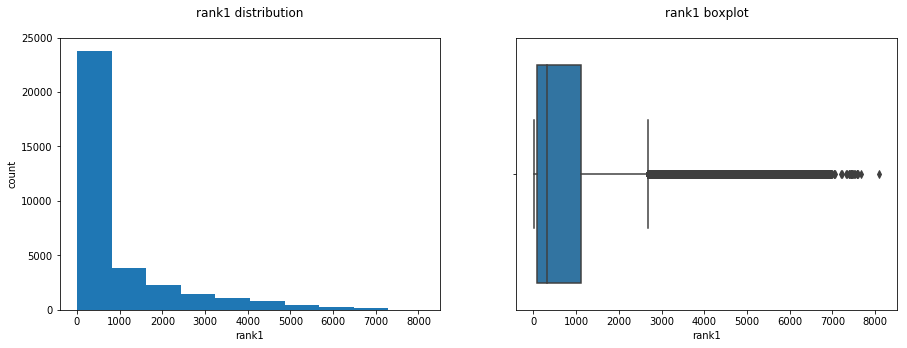

count    34122.000000
mean       913.529981
std       1344.582152
min          1.000000
25%         82.000000
50%        312.000000
75%       1119.750000
max       8104.000000
Name: rank1, dtype: float64

Пропуски: 15758


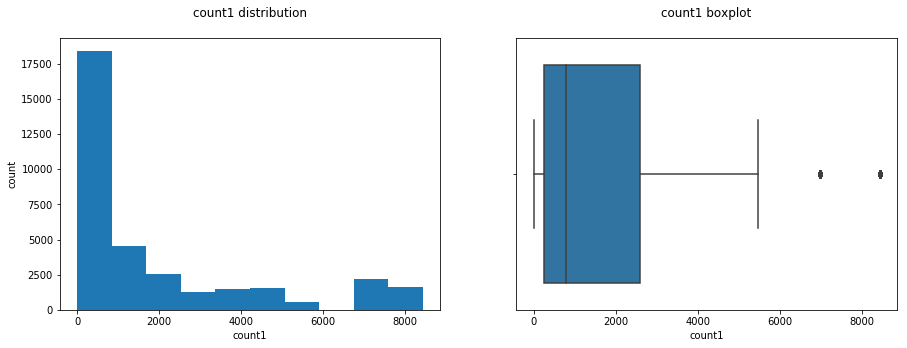

count    34122.000000
mean      1915.965975
std       2423.267370
min          1.000000
25%        243.000000
50%        779.000000
75%       2589.000000
max       8432.000000
Name: count1, dtype: float64

Пропуски: 15758


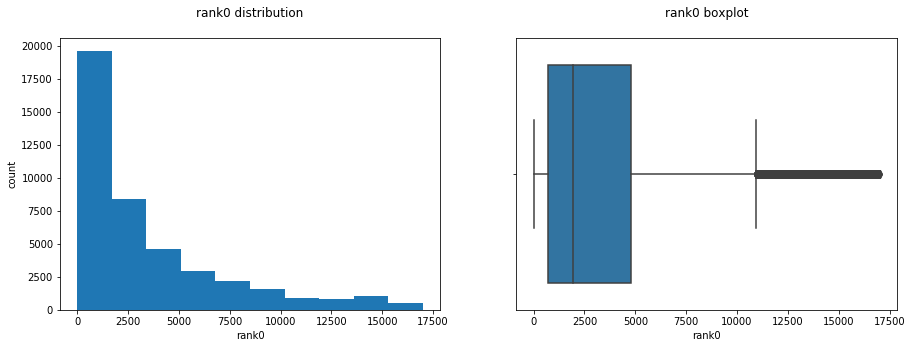

count    42576.000000
mean      3419.217987
std       3789.703469
min          1.000000
25%        703.000000
50%       1947.500000
75%       4793.250000
max      17005.000000
Name: rank0, dtype: float64

Пропуски: 7304


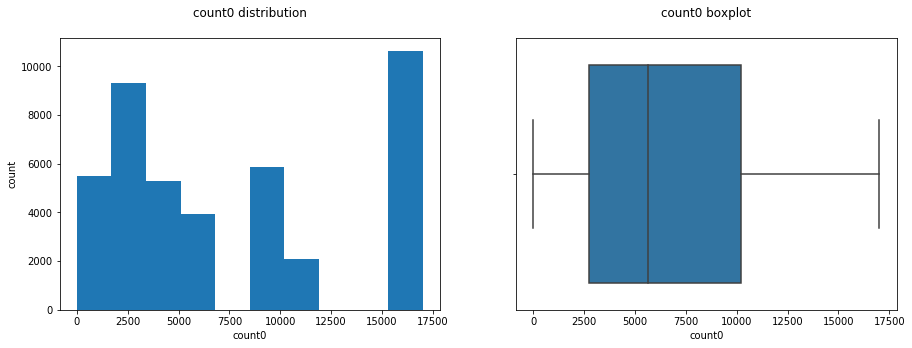

count    42576.000000
mean      7590.521233
std       5777.277025
min          1.000000
25%       2737.000000
50%       5619.000000
75%      10230.000000
max      17012.000000
Name: count0, dtype: float64

Пропуски: 7304


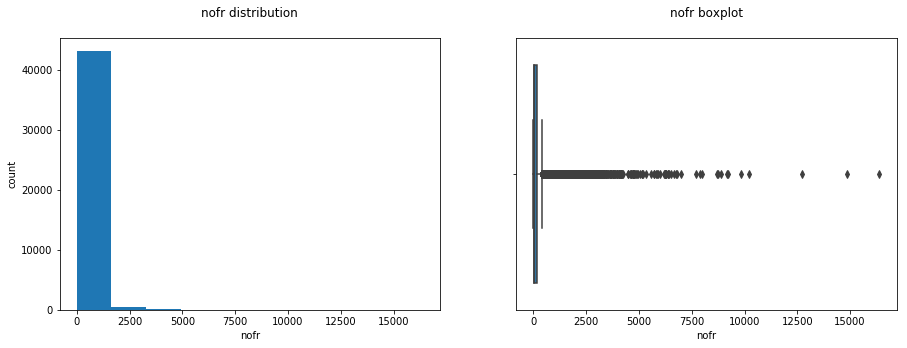

count    43814.000000
mean       180.563610
std        423.719996
min          1.000000
25%         13.000000
50%         48.000000
75%        169.000000
max      16381.000000
Name: nofr, dtype: float64

Пропуски: 6066


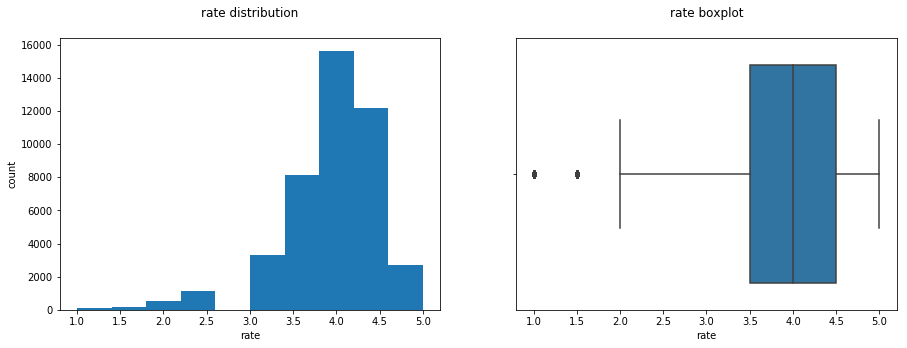

count    43814.000000
mean         3.952778
std          0.633845
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rate, dtype: float64

Пропуски: 6066


In [253]:
quick_look_numeric(df_grab, 'rank1')
quick_look_numeric(df_grab, 'count1')
quick_look_numeric(df_grab, 'rank0')
quick_look_numeric(df_grab, 'count0')
quick_look_numeric(df_grab, 'nofr')
quick_look_numeric(df_grab, 'rate')

In [254]:
class TripAdvisorExt(TripAdvisor):

    def __init__(self, df, ext_df, verbose = False):
        TripAdvisor.__init__(self, df, verbose = verbose)
        # !!! Удаляем rate от соблазна (хотя с ним получается mae=0.11 - видимо оценки изменились с 2018 года)
        self._ext_data = ext_df.drop(['rate'], axis=1).copy()
        # Merge datasets
        self._data = self._data.merge(self._ext_data, how='left')
        # rank1
        self._data['rank1'].fillna(0, inplace=True)
        # count1
        self._data['count1'].fillna(1, inplace=True)
        # rank0
        self._data['rank0'].fillna(0, inplace=True)
        # count0
        self._data['count0'].fillna(1, inplace=True)
        # nofr
        self._data['nofr'].fillna(0, inplace=True)

        self._data['rank1_rel'] = self._data['rank1'] / self._data['count1']
        self._data['rank0_rel'] = self._data['rank0'] / self._data['count0']

        
    def get_ext(self):
        return self._ext_data
    
    def get_data(self):
        return TripAdvisor.get_data(self).drop(['count0', 'count1'], axis=1)
    
    def __extract_price_range(self):
        details = self._data['details'].apply(
            lambda x: np.nan if len(str(x)) <= 3 else json.loads(str(x).replace("'", "\"").replace("RUB\\xa", "")))
        def extr_pr(x):
            x.setdefault('price range', '')
            return ''.join(x['price range'])
        pr = details.apply(lambda x: [] if pd.isna(x) else [f.strip() for f in extr_pr(x).replace(',_', '').split('-')])
        pr = pr.apply(lambda x: [int(i) if i != '' else 0 for i in x])
        return pr
  
    def __extract_cuisines(self):
        details = self._data['details'].apply(
            lambda x: np.nan if len(str(x)) <= 3 else json.loads(str(x).replace("'", "\"").replace("RUB\\xa", "")))
        def extr_cuisines(x):
            x.setdefault('cuisines', [])
            return x['cuisines']
        cuisines = details.apply(lambda x: [] if pd.isna(x) else extr_cuisines(x))
        cuisines = cuisines.apply(lambda x: [c.lower().strip() for c in x])
        return cuisines

    def __extract_meals(self):
        details = self._data['details'].apply(
            lambda x: np.nan if len(str(x)) <= 3 else json.loads(str(x).replace("'", "\"").replace("RUB\\xa", "")))
        def extr_meals(x):
            x.setdefault('meals', [])
            return x['meals']
        meals = details.apply(lambda x: [] if pd.isna(x) else extr_meals(x))
        return meals

    def __extract_features(self):
        details = self._data['details'].apply(
            lambda x: np.nan if len(str(x)) <= 3 else json.loads(str(x).replace("'", "\"").replace("RUB\\xa", "")))
        def extr_features(x):
            x.setdefault('features', [])
            return x['features']
        features = details.apply(lambda x: [] if pd.isna(x) else extr_features(x))
        return features

        


#### Запускаем и проверяем что получилось

In [255]:
ta = TripAdvisorExt(data, df_grab, verbose=True).generate().rest_look().review_actual()
ta.days_between_review()
ta.rest_in_city()
ta.rest_styles_count()
ta.freq_styles()
ta.dummy_city()
ta.dummy_style()

i: Относительный ранг ресторана к размаху ранга по горроду
i: Кол-во дней с публикации отзывов
i: Длин названия ресторана
i: Полярность отзывов
i: Label encoding для цены
i: Привлекательность ресторана по соотношению кол-во отзывов на ранг и цену
i: Актуальность отзывов (кол-во на давность)
i: Дней между отзывами
i: Кол-во ресторанов в городе
i: Кол-во кухонь представленных в ресторане
i: Частота кухонь в городе
i: Dummy encoding для города
i: Encoding для кухонь


In [256]:
df_preproc = ta.get_data()
df_preproc.sample(10)

,Ranking,Number_of_Reviews,sample,Rating,duplicated_ta_id,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,review1_isNAN,review2_isNAN,...,Style_unknown,Style_uzbek,Style_vegan_options,Style_vegetarian_friendly,Style_venezuelan,Style_vietnamese,Style_welsh,Style_wine_bar,Style_xinjiang,Style_yunnan
46055,6977.0,4.0,1,3.0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
44317,3659.0,16.0,1,4.5,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
47016,6660.0,12.0,1,3.5,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
2533,668.0,45.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44083,148.0,62.0,1,4.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38858,1688.0,67.0,1,4.5,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
39779,6967.0,7.0,1,3.5,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
871,5900.0,5.0,0,0.0,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
46223,6412.0,32.0,1,4.0,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
36140,3444.0,172.0,1,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [257]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 311 entries, Ranking to Style_yunnan
dtypes: float64(140), int64(8), uint8(163)
memory usage: 64.6 MB


In [258]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [259]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [260]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 310), (40000, 310), (40000, 309), (32000, 309), (8000, 309))

# Model 
Сам ML

In [261]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [262]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [263]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred

#y_pred = model.predict(X_test)
y_pred = np.round(model.predict(X_test) * 2) / 2

y_pred = [1 if y < 1 else 5 if y > 5 else y for y in y_pred]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [264]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1505


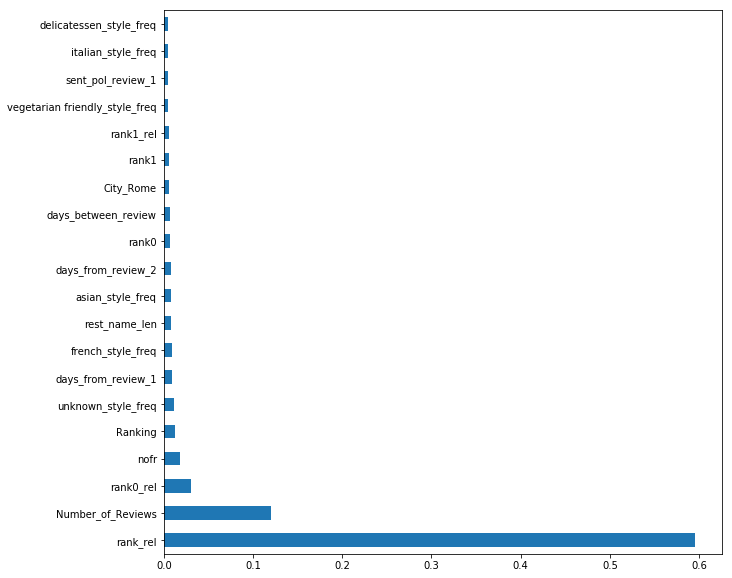

In [265]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [266]:
# Обучим модель на всем наборе
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [267]:
test_data.sample(10)

,Ranking,Number_of_Reviews,Rating,duplicated_ta_id,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,review1_isNAN,review2_isNAN,rank1,...,Style_unknown,Style_uzbek,Style_vegan_options,Style_vegetarian_friendly,Style_venezuelan,Style_vietnamese,Style_welsh,Style_wine_bar,Style_xinjiang,Style_yunnan
5189,9983.0,13.0,0.0,0,0,0,0,0,0,650.0,...,0,0,0,0,0,0,0,0,0,0
5618,7471.0,8.0,0.0,0,0,1,1,0,0,386.0,...,1,0,0,0,0,0,0,0,0,0
9379,9383.0,4.0,0.0,0,0,1,0,0,0,138.0,...,0,0,0,0,0,0,0,0,0,0
9240,2060.0,4.0,0.0,0,0,1,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
7726,6898.0,70.0,0.0,0,0,1,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
5851,10512.0,20.0,0.0,0,0,0,0,0,0,0.0,...,0,0,1,1,0,0,0,0,0,0
2777,939.0,48.0,0.0,0,0,0,0,0,0,63.0,...,0,0,0,0,0,0,0,0,0,0
5066,5795.0,10.0,0.0,0,0,1,1,1,1,4704.0,...,1,0,0,0,0,0,0,0,0,0
5932,1119.0,10.0,0.0,0,0,1,0,1,1,168.0,...,0,0,0,0,0,0,0,0,0,0
3115,4550.0,37.0,0.0,0,0,0,0,0,0,3437.0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
test_data = test_data.drop(['Rating'], axis=1)

In [269]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [270]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [271]:
predict_submission

array([3.1  , 4.25 , 4.435, ..., 3.09 , 4.325, 4.335])

In [272]:
# Округлим predict_submission до .5
predict_submission = np.round(predict_submission * 2) / 2
predict_submission = np.array([1 if y < 1 else 5 if y > 5 else y for y in predict_submission])
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [273]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!